In [168]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np

warnings.filterwarnings('ignore')

In [169]:
df_A_fullday = pd.read_csv('processed_datasets/fulldata/A.csv')
df_A_daytime = pd.read_csv('processed_datasets/filtereddata/A.csv')
df_B_fullday = pd.read_csv('processed_datasets/fulldata/B.csv')
df_B_daytime = pd.read_csv('processed_datasets/filtereddata/B.csv')
df_A_daytime.head()

Day_name        Date      Time             DateTime  Batch requests/sec  \
0      Fri  2024-05-03  05:00:00  2024-05-03 05:00:00           25.612128   
1      Fri  2024-05-03  05:01:00  2024-05-03 05:01:00           47.598731   
2      Fri  2024-05-03  05:02:00  2024-05-03 05:02:00           36.154191   
3      Fri  2024-05-03  05:03:00  2024-05-03 05:03:00           39.685927   
4      Fri  2024-05-03  05:04:00  2024-05-03 05:04:00           32.420153   

   User connections  Processor Time  Free memory  Page reads/sec  \
0            1481.0        9.791666    10.782990     3676.942425   
1            1567.0        8.667025    11.932884      293.252145   
2            1597.0        9.559476    11.942520      259.627080   
3            1614.0        8.513114    11.956818      126.319841   
4            1631.0       12.785351    11.634457      911.450175   

   Disk avg. read time > M: Data 1  Disk avg. read time > N: Data 2  \
0                          1.50820                           1.5927   
1                          1.60525                           1.3690   
2                          1.57680                           1.5917   
3                          0.71930                           0.6896   
4                          1.41990                           1.5133   

   Disk avg. read time > I: Index  Disk avg. write time > M: Data 1  \
0                         5.81910                            0.3953   
1                         2.16755                            0.5146   
2                         2.31440                            0.3801   
3                         0.63690                            0.3643   
4                         3.19270                            0.0000   

   Disk avg. write time > N: Data 2  Disk avg. write time > I: Index  \
0                            0.0000                          0.00000   
1                            0.5562                          0.33385   
2                            0.0000                          0.00000   
3                            0.3723                          0.00000   
4                            0.0000                          0.00000   

   Compilations/batch  Latch wait time  Disk avg. read time data  \
0           30.808511          0.89970                   3.10090   
1           17.584369          0.52950                   2.97425   
2            7.741935          1.37780                   3.16850   
3            5.484051          0.98900                   1.40890   
4           22.108495          0.95835                   2.93320   

   Disk avg. write time data  
0                     0.3953  
1                     1.0708  
2                     0.3801  
3                     0.7366  
4                     0.0000

In [170]:
df_A_fullday.fillna(0, inplace=True)
df_A_daytime.fillna(0, inplace=True)
df_B_fullday.fillna(0, inplace=True)
df_B_daytime.fillna(0, inplace=True)


In [172]:
def fontdict(fontsize=16, fontweight='bold', fontname='Arial'):
  return {'fontsize':fontsize, 'fontweight': fontweight, 'fontname':fontname}

In [173]:
def concat_df(dfA, dfB):
  dfA['A/B'] = 'A'
  dfB['A/B']= 'B'
  return pd.concat([dfA,dfB], axis=0).reset_index(drop=True)

In [174]:
def order_by_dayname(data, order = ['Day_name','Time']):
  day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
  data['Day_name'] = pd.Categorical(data['Day_name'], categories=day_order, ordered=True)
  data = data.sort_values(by=order)
  return data

In [175]:
df_daytime = concat_df(df_A_daytime, df_B_daytime)

df_A_daytime = order_by_dayname(df_A_daytime)
df_B_daytime = order_by_dayname(df_B_daytime)

df_daytime = df_daytime.sort_values(by=['Date','Time'])

df_daytime['Hour'] = pd.to_datetime(df_daytime['Time']).dt.hour
df_A_daytime['Hour'] = pd.to_datetime(df_daytime['Time']).dt.hour
df_B_daytime['Hour'] = pd.to_datetime(df_daytime['Time']).dt.hour

df_daytime = df_daytime.dropna()
df_A_daytime = df_A_daytime.dropna()
df_B_daytime = df_B_daytime.dropna()

In [176]:
df_daytime['A/B'].value_counts()

A/B
A    3305
B    3305
Name: count, dtype: int64

In [177]:
metric_cols = ['Batch requests/sec',
       'User connections', 'Processor Time', 'Free memory', 'Page reads/sec',
       'Disk avg. read time > I: Index',
       'Disk avg. write time > I: Index',
       'Compilations/batch', 'Latch wait time', 'Disk avg. read time data',
       'Disk avg. write time data', ]

In [178]:
perf_cols = ['Processor Time', 'Free memory', 'Page reads/sec',
             'Disk avg. read time > I: Index',
             'Disk avg. write time > I: Index',
             'Compilations/batch', 'Latch wait time', 
             'Disk avg. read time data',
             'Disk avg. write time data']

## Daytime data

### Workload 
Indicate how busy the server is 
- **Batch requests/sec**: It measures the number of batches received by the SQL Server per second.
- **User connections**: t measures the number of user connections to a SQL Server instance at a given time.

In [179]:
def plot_A_vs_B_metric_per_hour(metric_name, ax):
    df_A_mean = df_A_daytime.groupby(['Day_name', 'Hour'])[metric_name].mean()
    df_B_mean = df_B_daytime.groupby(['Day_name', 'Hour'])[metric_name].mean()

    df_A_mean.plot(label='A', ax=ax)
    df_B_mean.plot(label='B', ax=ax)

    day_hour_labels = df_A_mean.index.tolist()
    day_hour_str_labels = [f'{day} {hour}' for day, hour in day_hour_labels]

    ax.set_xticks(range(len(day_hour_labels)))
    ax.set_xticklabels(day_hour_str_labels, rotation=45, ha='right')
    ax.set_title(f'{metric_name} over week (per Hour)', fontdict=fontdict())
    ax.legend()
    ax.set_xlabel('Time')

def plot_A_vs_B_metric_per_minute(metric_name, ax):
    df_A_mean = df_A_daytime[metric_name]
    df_B_mean = df_B_daytime[metric_name]

    df_A_mean.plot(label='A', ax=ax)
    df_B_mean.plot(label='B', ax=ax)
    
    ax.set_title(f'{metric_name} over week (per Min)', fontdict=fontdict())
    ax.legend()
    ax.set_xlabel('Time')

def plot_A_vs_B_metric_per_day(metric_name, ax):
    df_A_mean = df_A_daytime.groupby('Day_name')[metric_name].mean()
    df_B_mean = df_B_daytime.groupby('Day_name')[metric_name].mean()

    df_A_mean.plot(label='A', ax=ax)
    df_B_mean.plot(label='B', ax=ax)

    ax.set_title(f'{metric_name} over week (per Day)', fontdict=fontdict())
    ax.legend()
    ax.set_xlabel('Day of the Week')

def group_data(data,metric, period):
  group =  data.groupby(['A/B',period])[metric].mean().reset_index()
  return group

def plot_boxplot(metric_name,ax=False, period = 'min'):
  data=group_data(df_daytime, metric_name, period) if period != 'min' else df_daytime
  if ax:
    sns.boxplot(data, y= metric_name, hue='A/B', ax=ax)
    ax.set_title(f'{metric_name} (per {period}) ', fontdict=fontdict())
    ax.set_ylabel(None)
  else:
    sns.boxplot(data, y= metric_name, hue='A/B')
    plt.title(f'{metric_name} (per {period}) ', fontdict=fontdict())
  plt.tight_layout()

def plot_heatmap(df, title):
  mask = np.zeros_like(df.astype(float).corr())
  mask[np.triu_indices_from(mask)] =True 
  colormap = plt.cm.RdBu_r
  plt.figure(figsize=(16,8))
  plt.title(f'{title}', fontdict=fontdict(), y= 1.02)
  plt.grid(False)
  sns.heatmap(round(df.astype(float).corr(),2),linewidths=0.1, 
              vmax=1.0,vmin=-1.0, 
              square=True, cmap=colormap,linecolor='white',
              annot=True, annot_kws={'size':10},mask=mask)
  plt.xticks(fontsize=10, rotation = 30, ha='right')


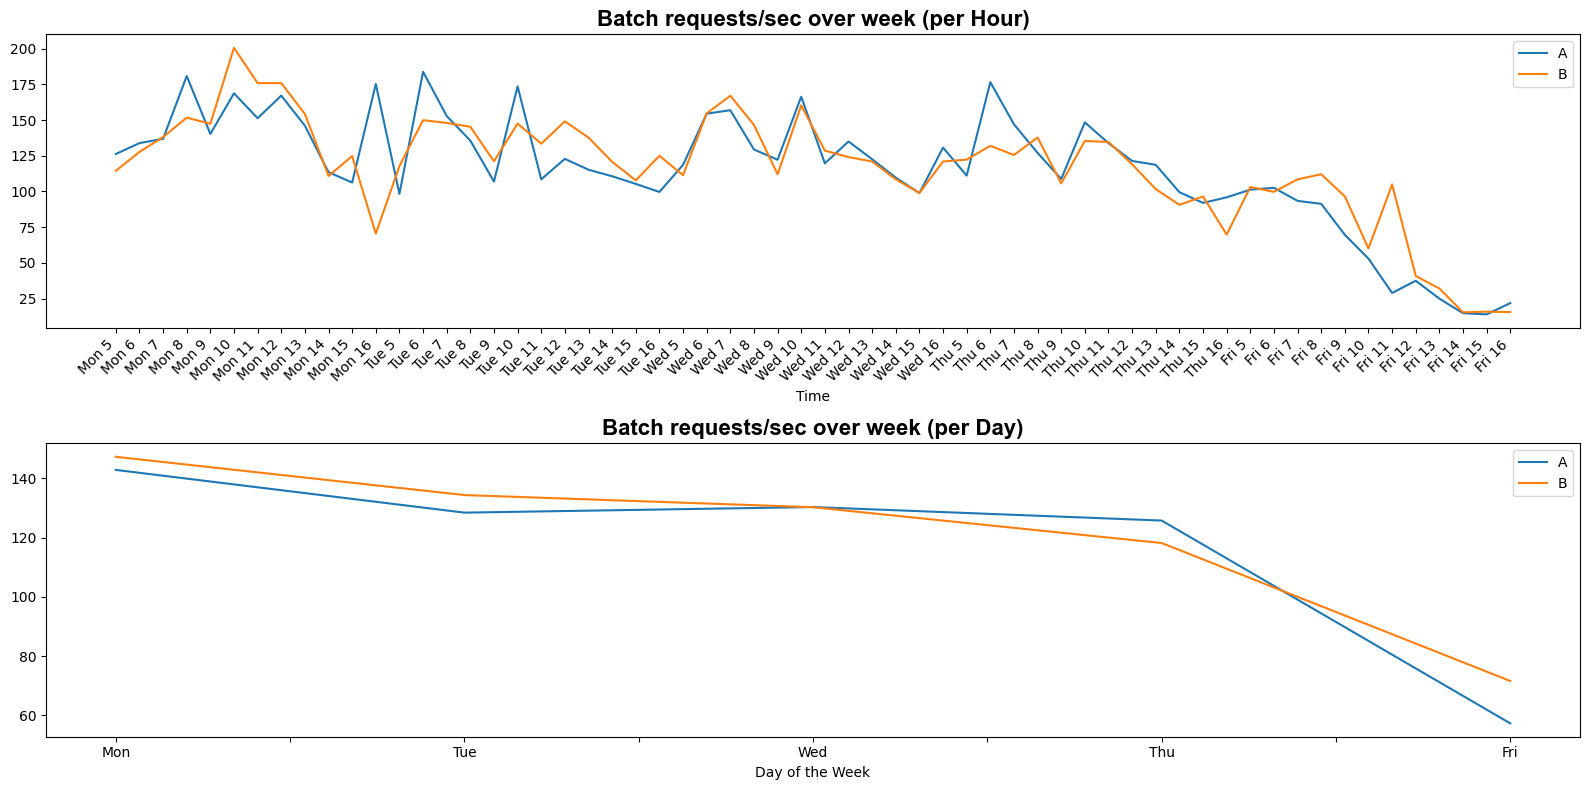

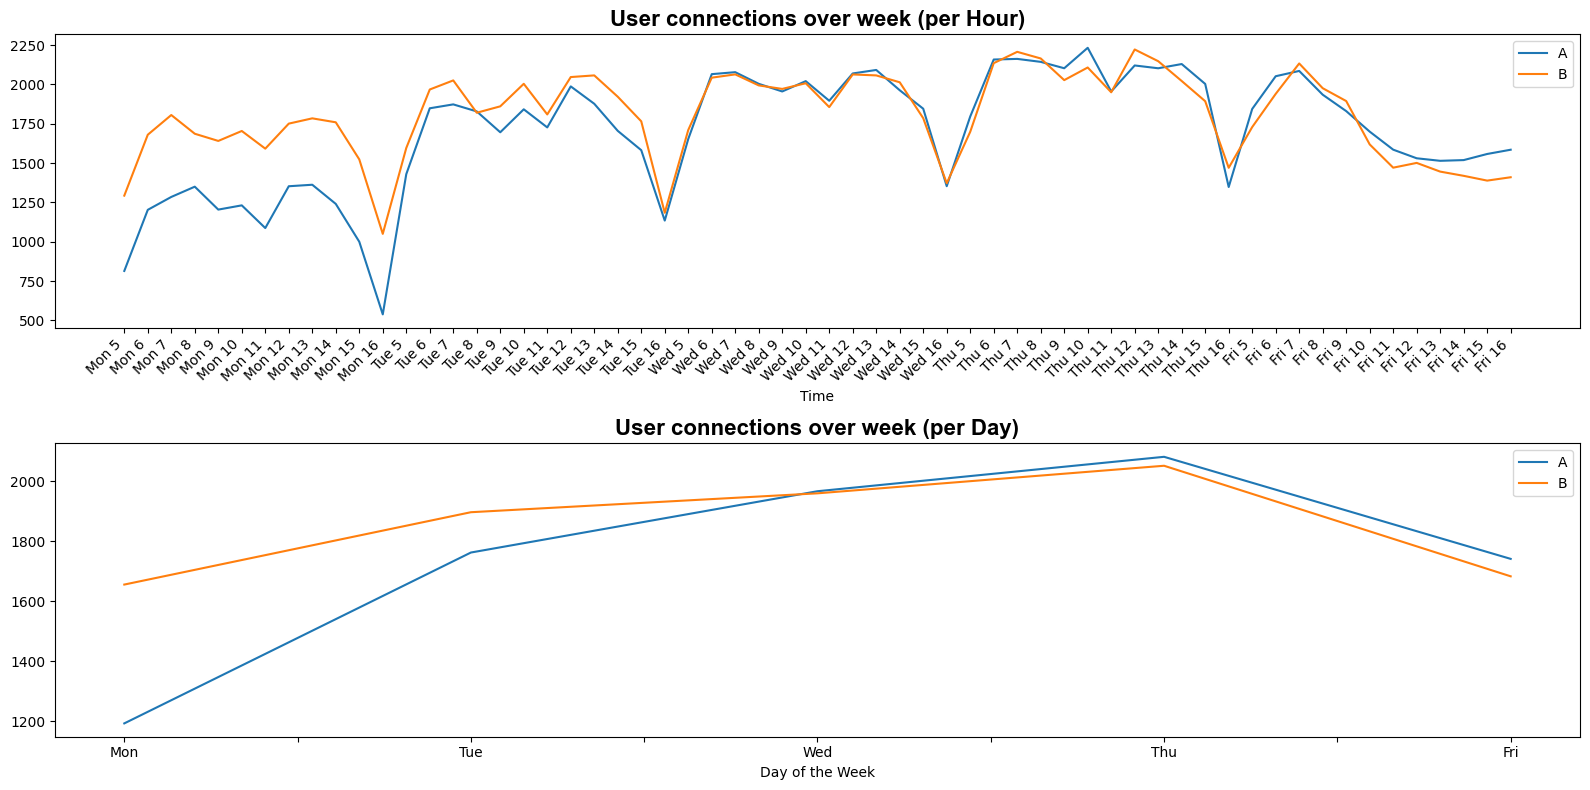

In [180]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,8))
plot_A_vs_B_metric_per_hour('Batch requests/sec', ax1)
plot_A_vs_B_metric_per_day('Batch requests/sec', ax2)
plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,8))
plot_A_vs_B_metric_per_hour('User connections', ax1)
plot_A_vs_B_metric_per_day('User connections', ax2)
plt.tight_layout()

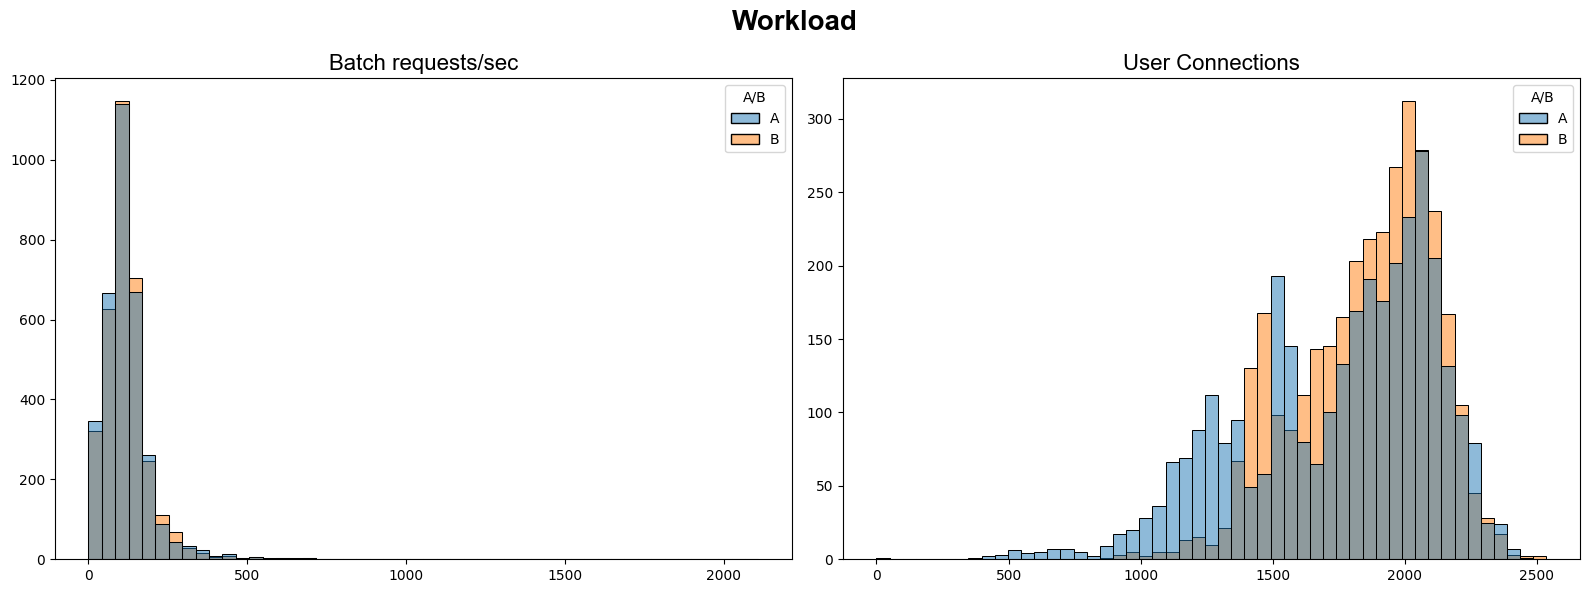

In [181]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))

sns.histplot(data=df_daytime, x='Batch requests/sec', hue='A/B',ax=ax1, bins=50)
sns.histplot(data=df_daytime, x='User connections', hue='A/B', ax=ax2)

plt.suptitle('Workload', fontsize=20, fontweight='bold', fontname='Arial')

ax1.set_title('Batch requests/sec', fontdict=fontdict(fontweight='medium'))
ax2.set_title('User Connections', fontdict=fontdict(fontweight='medium'))

ax1.set_xlabel(None)
ax2.set_xlabel(None)

ax1.set_ylabel(None)
ax2.set_ylabel(None)

plt.tight_layout()

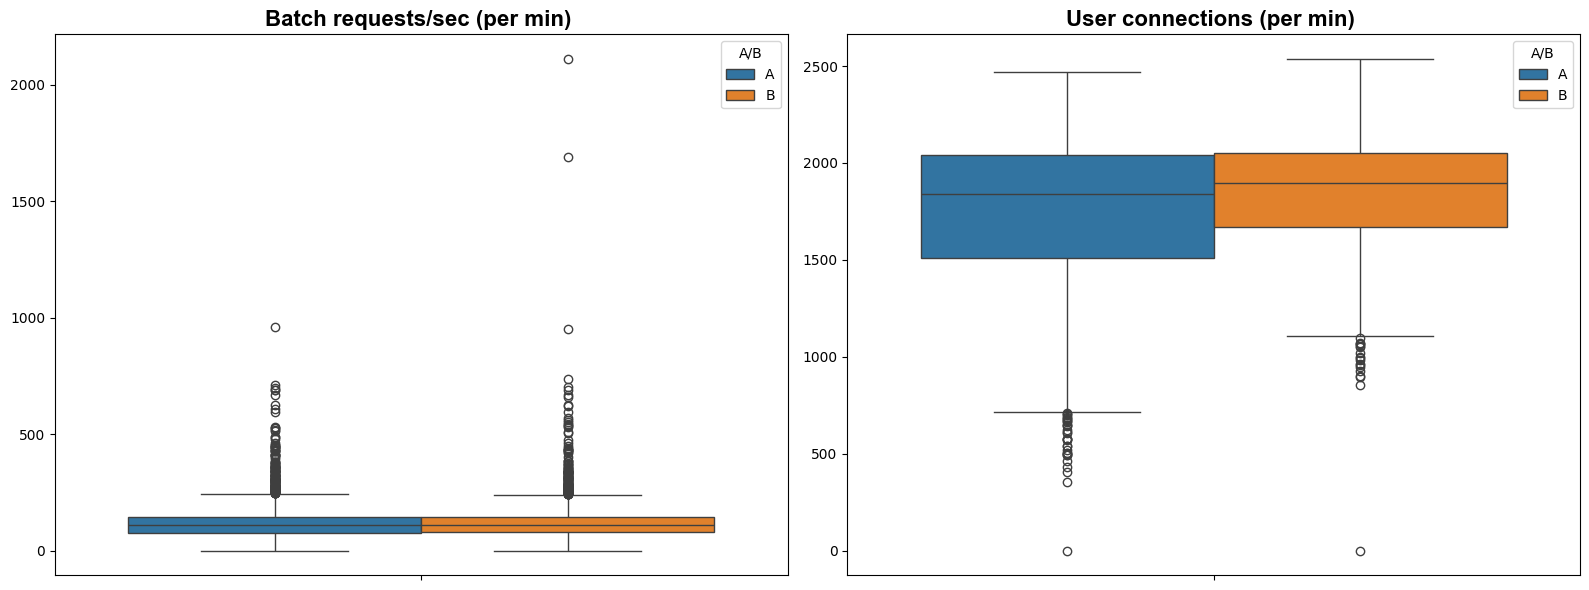

In [182]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))
plot_boxplot('Batch requests/sec',ax1)
plot_boxplot('User connections', ax2)


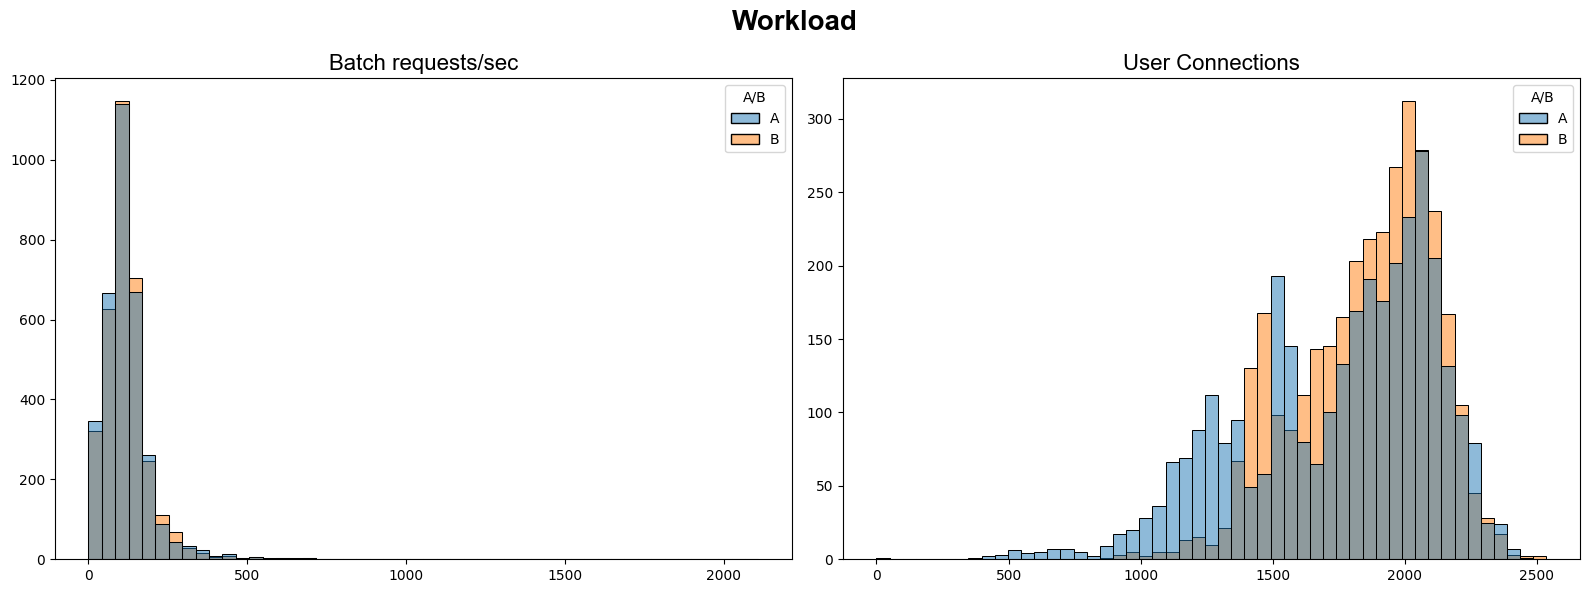

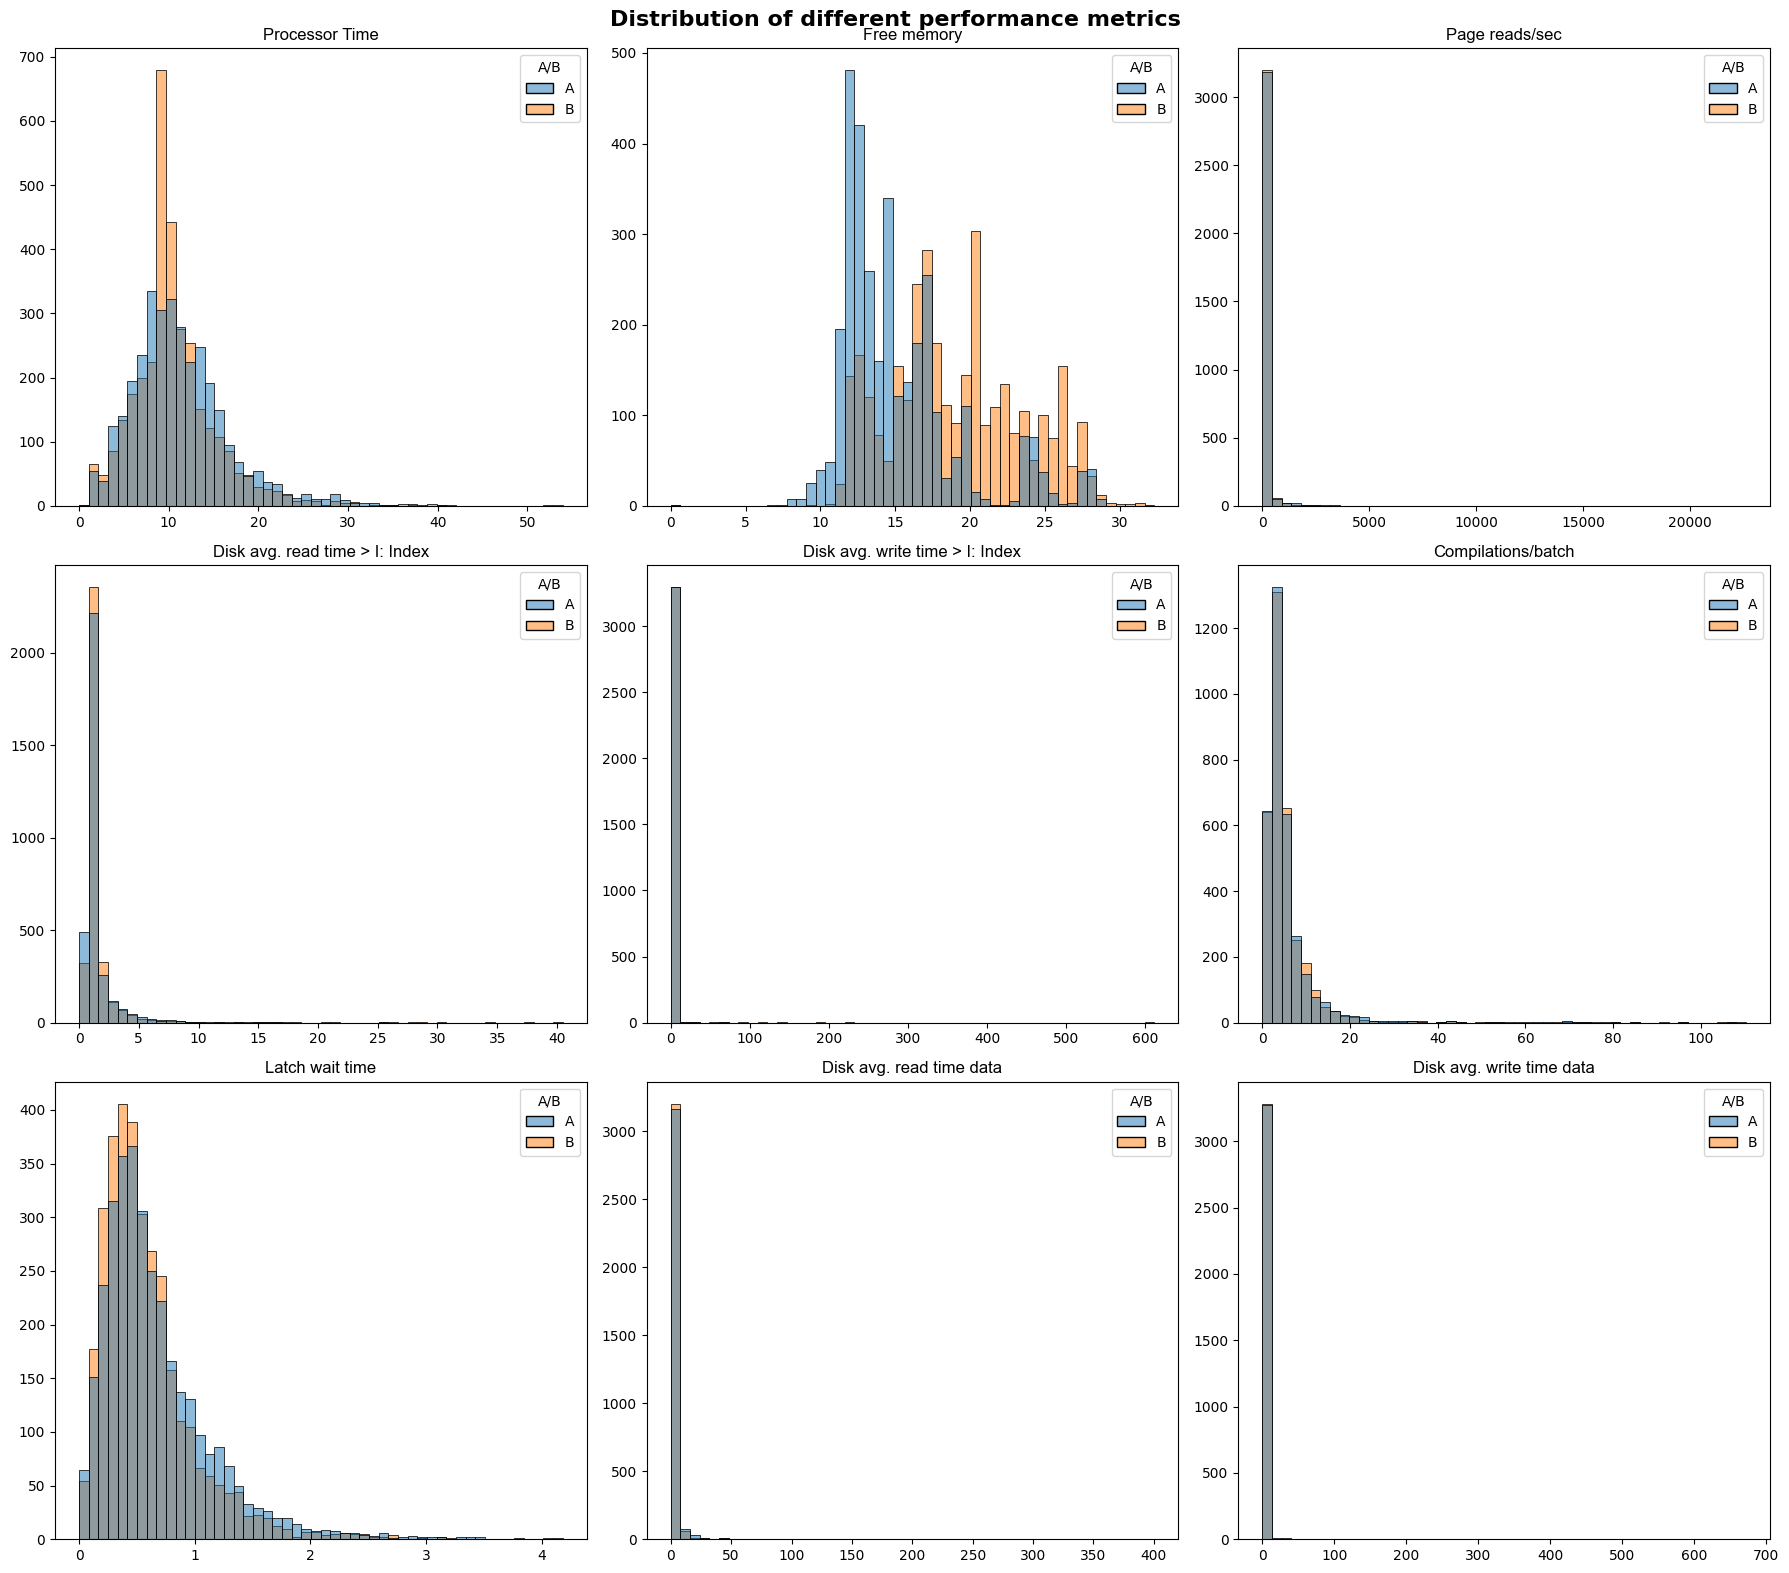

In [183]:

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))

sns.histplot(data=df_daytime, x='Batch requests/sec', hue='A/B',ax=ax1, bins=50)
sns.histplot(data=df_daytime, x='User connections', hue='A/B', ax=ax2)

plt.suptitle('Workload', fontsize=20, fontweight='bold', fontname='Arial')
ax1.set_title('Batch requests/sec', fontdict=fontdict(fontweight='medium'))
ax2.set_title('User Connections', fontdict=fontdict(fontweight='medium'))
ax1.set_xlabel(None)
ax2.set_xlabel(None)
ax1.set_ylabel(None)
ax2.set_ylabel(None)

plt.tight_layout()

fig, axes = plt.subplots(3,3, figsize = (18,16))
axes = axes.flatten()

for i,perf_col in enumerate(perf_cols):
  sns.histplot(data = df_daytime, x= perf_col, hue='A/B', ax=axes[i], bins=50)
  axes[i].set_title(f'{perf_col}', fontdict=fontdict(12,'medium'))
  axes[i].set_xlabel('')
  axes[i].set_ylabel('')

fig.suptitle('Distribution of different performance metrics', fontsize=16, fontweight='bold' )

plt.tight_layout()



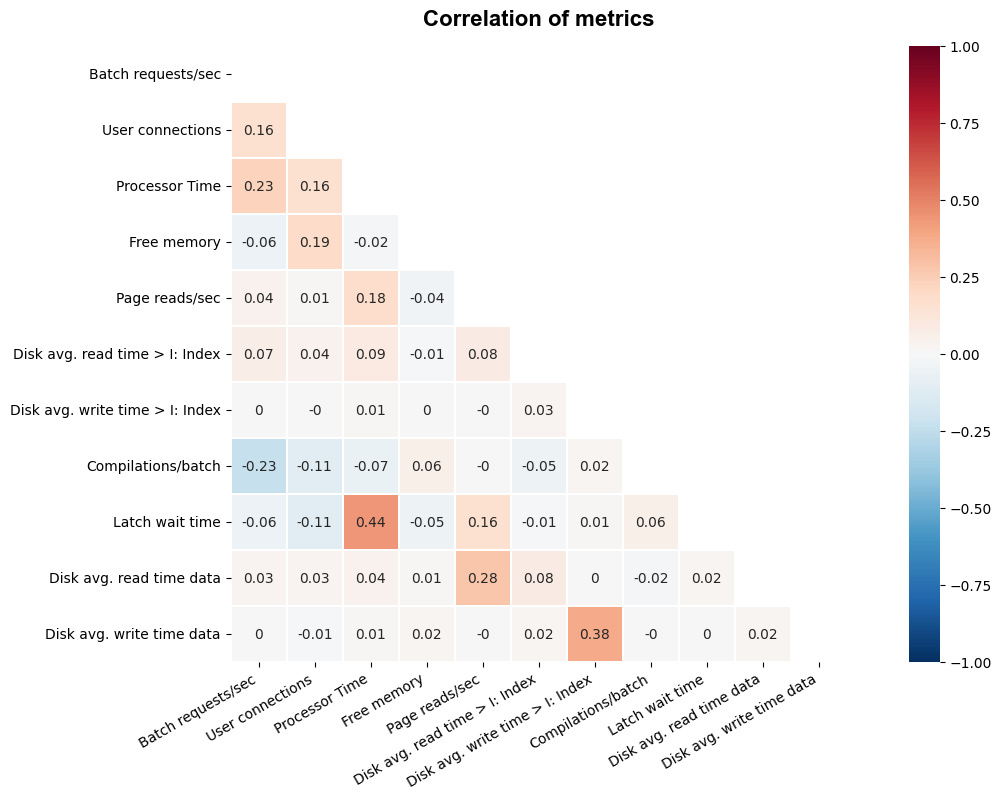

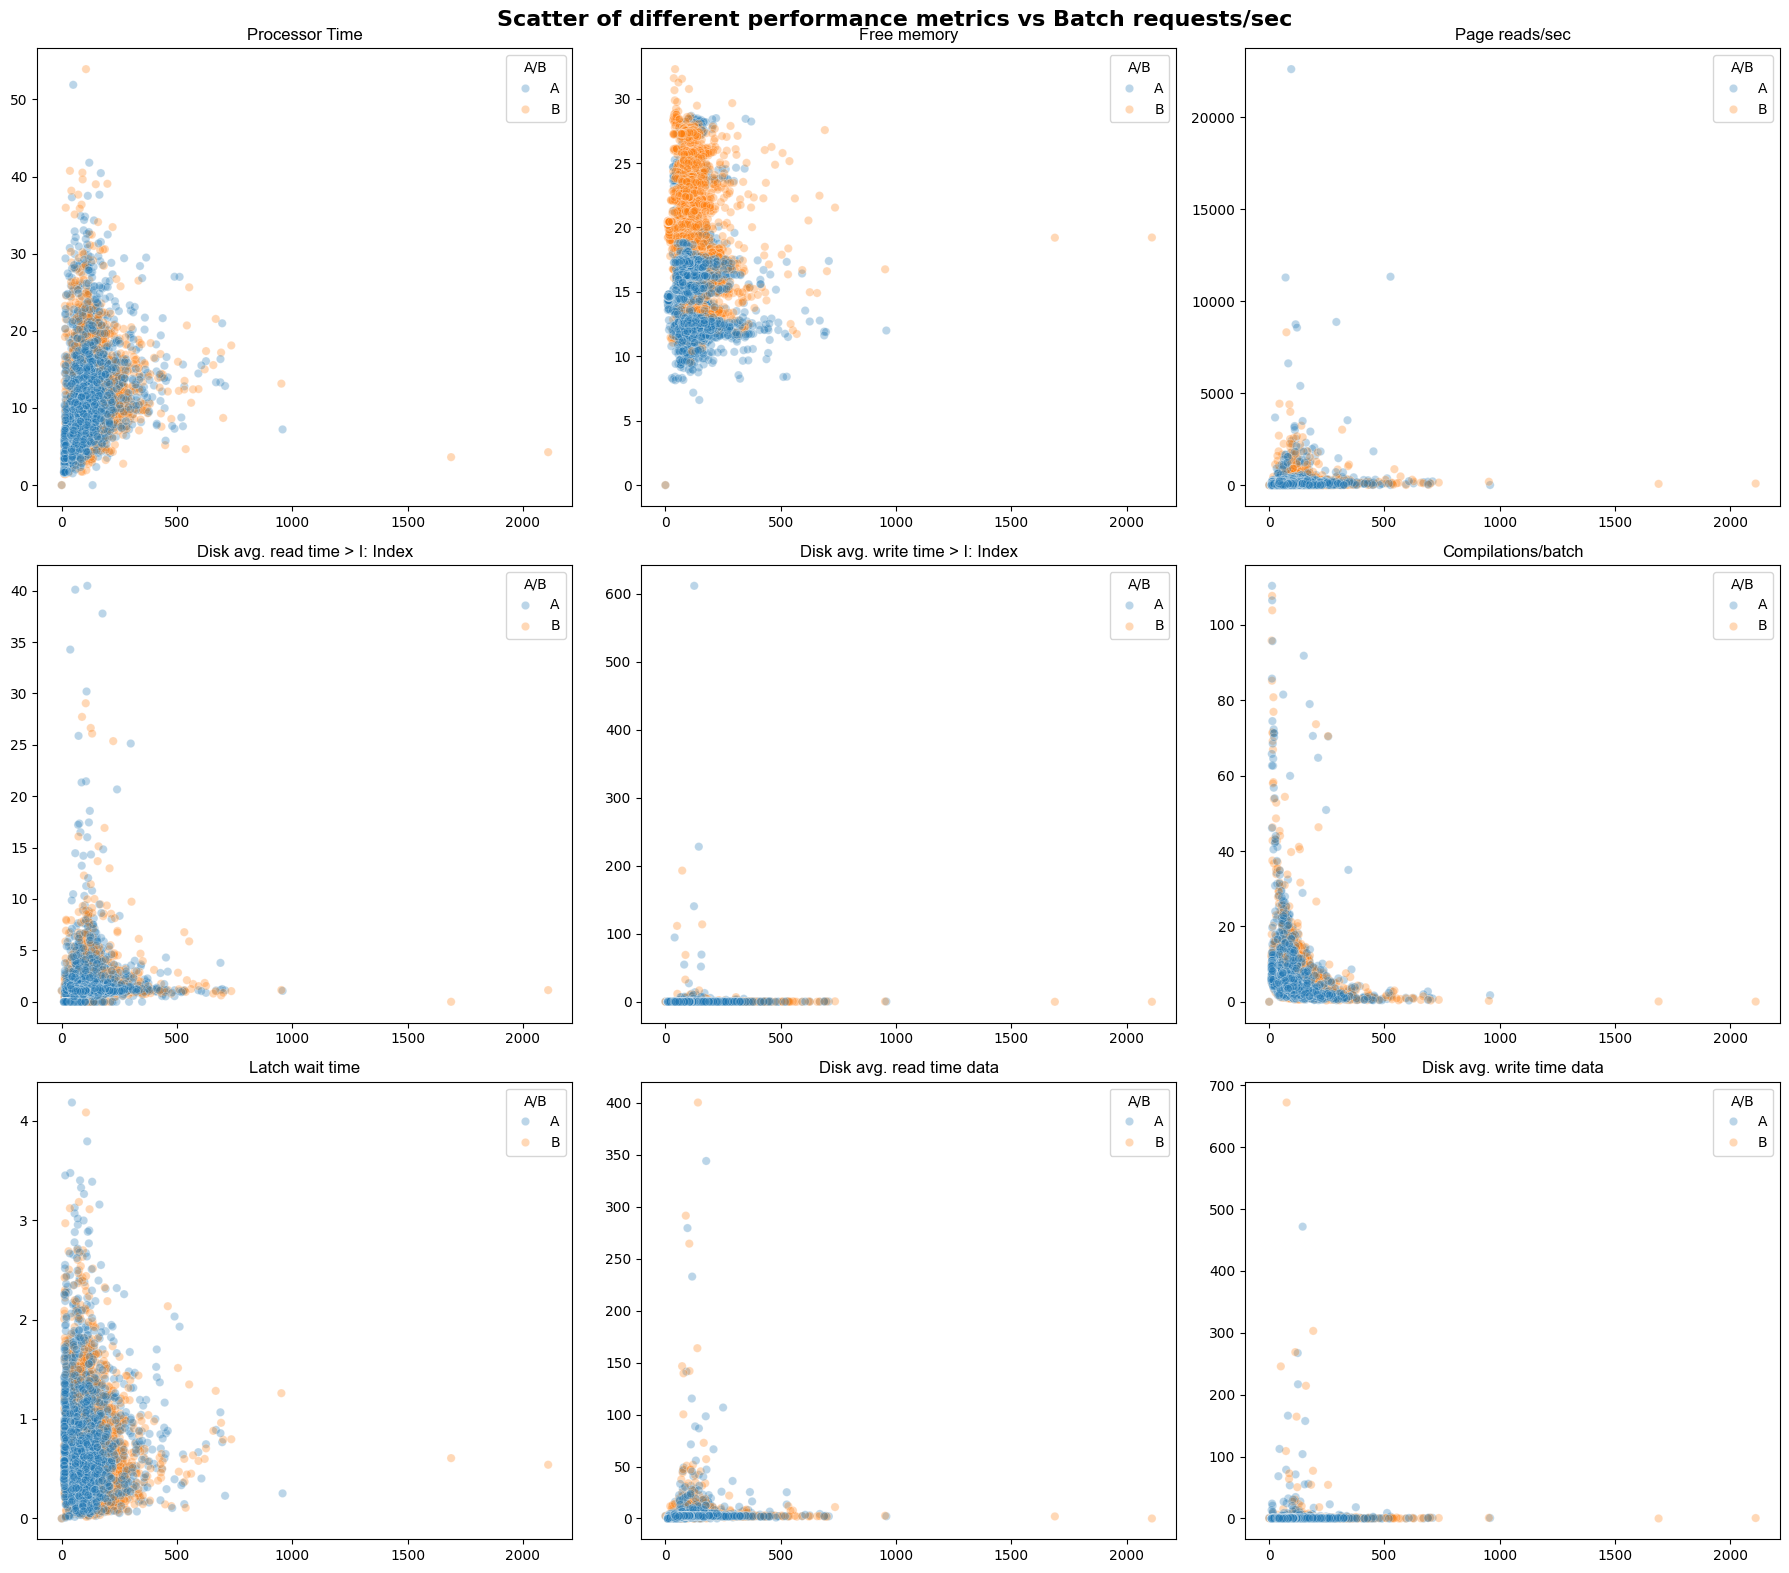

In [184]:

plot_heatmap(df_daytime[metric_cols], title='Correlation of metrics')

fig, axes = plt.subplots(3,3, figsize = (18,16))

axes = axes.flatten()

for i,perf_col in enumerate(perf_cols):
  sns.scatterplot(data = df_daytime, x= 'Batch requests/sec',y=perf_col, hue='A/B', ax=axes[i], alpha=0.3)
  axes[i].set_title(f'{perf_col}', fontdict=fontdict(12,'medium'))
  axes[i].set_xlabel(None)
  axes[i].set_ylabel(None)

fig.suptitle('Scatter of different performance metrics vs Batch requests/sec', fontsize=16, fontweight='bold' )

plt.tight_layout()


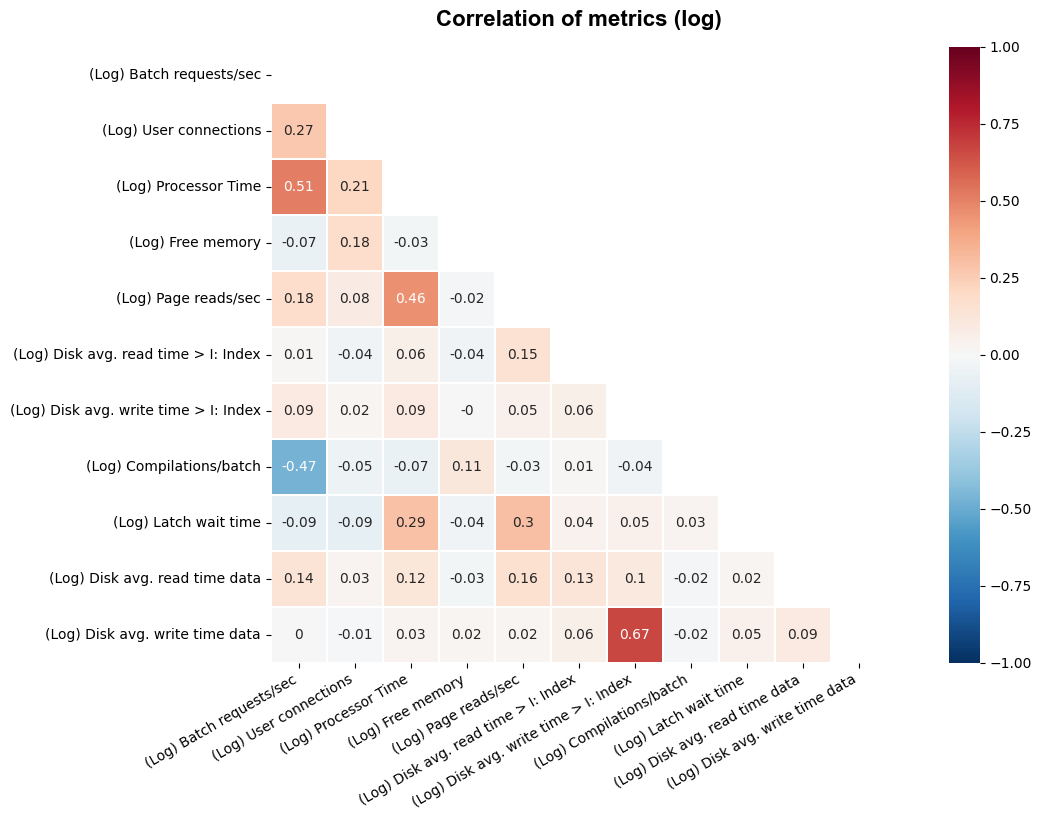

In [185]:
log_metric_cols = ['(Log) '+i for i in metric_cols]
log_perf_cols = ['(Log) ' + i for i in perf_cols]
for i, metric_col in enumerate(metric_cols):
  df_daytime[f'(Log) {metric_col}'] = np.log(df_daytime[metric_col])

plot_heatmap(df_daytime[log_metric_cols], title='Correlation of metrics (log)')


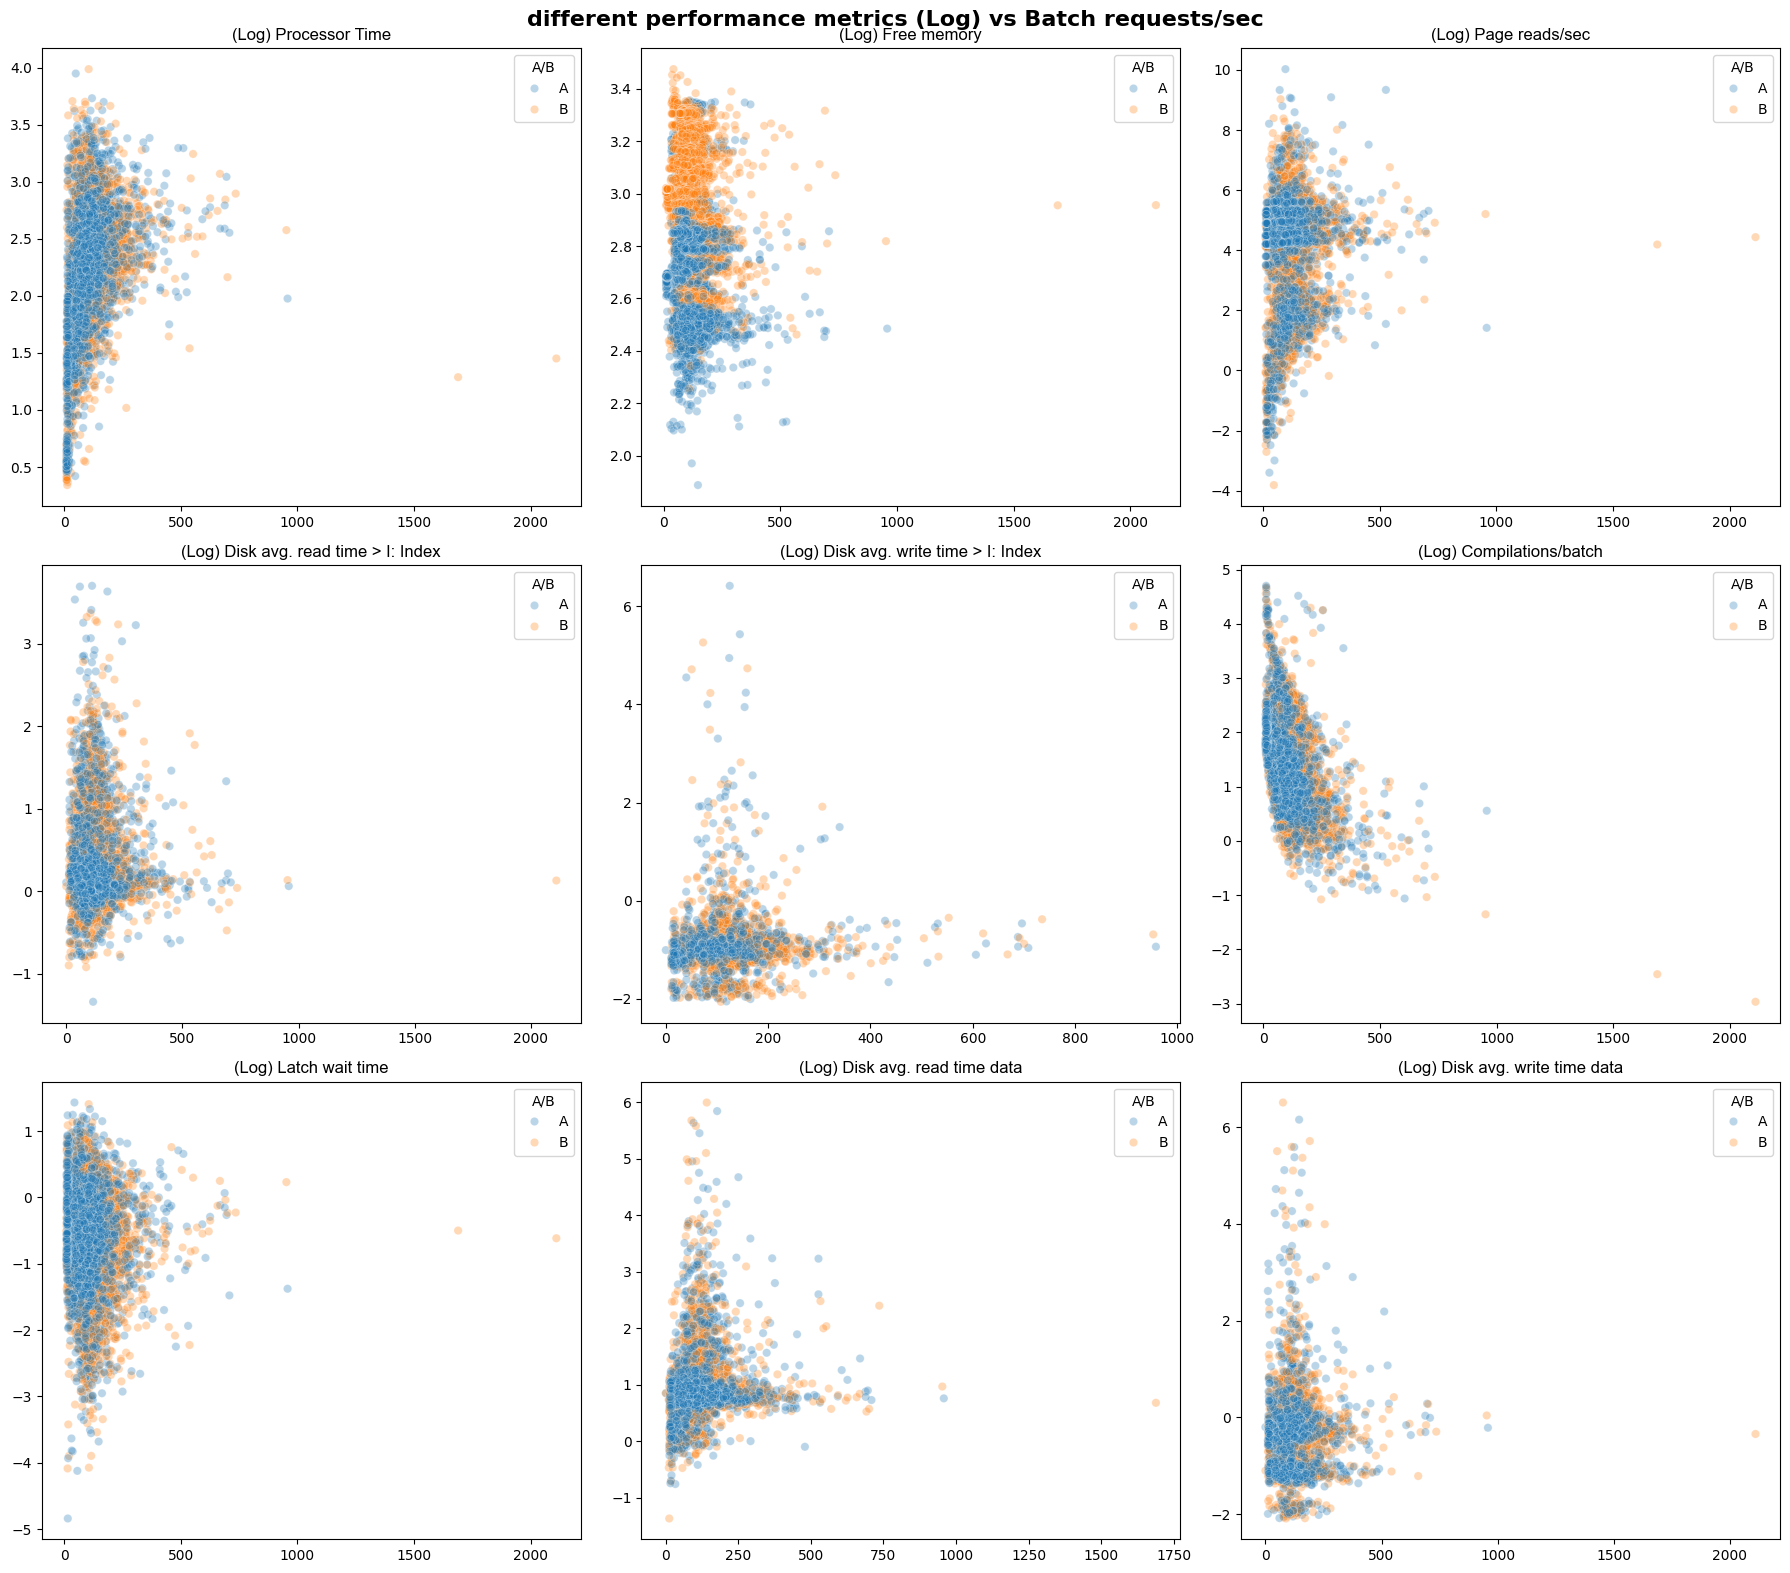

In [186]:
fig, axes = plt.subplots(3,3, figsize = (18,16))

axes = axes.flatten()

for i,log_perf_col in enumerate(log_perf_cols):
  sns.scatterplot(data = df_daytime, x= 'Batch requests/sec',y=log_perf_col, hue='A/B', ax=axes[i], alpha=0.3)
  axes[i].set_title(f'{log_perf_col}', fontdict=fontdict(12,'medium'))
  axes[i].set_xlabel(None)
  axes[i].set_ylabel(None)

fig.suptitle('different performance metrics (Log) vs Batch requests/sec', fontsize=16, fontweight='bold' )

plt.tight_layout()

In [187]:
def plot_workload_vs_performance_per_hour(data,A_or_B, workload_metric, performance_metric, ax1):
    
  workload_mean = data.groupby(['Day_name', 'Hour'])[workload_metric].mean()
  performance_mean = data.groupby(['Day_name', 'Hour'])[performance_metric].mean()
  
  performance_mean.plot(label=f'{performance_metric}', ax=ax1, color='#ffbf00')
  ax1.set_ylabel(f'{performance_metric}', color='#ffbf00')
  ax1.tick_params(axis='y', labelcolor='#ffbf00')

  ax2 = ax1.twinx()

  workload_mean.plot(label=f'{workload_metric}', ax=ax2, color='#247639')
  ax2.set_ylabel(f'{workload_metric}', color='#247639')
  ax2.tick_params(axis='y', labelcolor='#073763')

  ax1.legend(loc='upper left')
  ax2.legend(loc='upper right')
  plt.title(f"{A_or_B}'s {performance_metric} vs {workload_metric} over week (per Hour)", fontdict=fontdict())


def plot_workload_vs_performance_per_day(data, A_or_B, workload_metric, performance_metric, ax1=ax1):
    
  workload_mean = data.groupby(['Day_name'])[workload_metric].mean()
  performance_mean = data.groupby(['Day_name'])[performance_metric].mean()
  
  performance_mean.plot(label=f'{performance_metric}', ax=ax1, color='#ffbf00')
  ax1.set_ylabel(f'{performance_metric}', color='#ffbf00')
  ax1.tick_params(axis='y', labelcolor='#ffbf00')

  ax2 = ax1.twinx()

  workload_mean.plot(label=f'{workload_metric}', ax=ax2, color='#247639')
  ax2.set_ylabel(f'{workload_metric}', color='#247639')
  ax2.tick_params(axis='y', labelcolor='#073763')

  ax1.legend(loc='upper left')
  ax2.legend(loc='upper right')
  plt.title(f"{A_or_B}'s {performance_metric} vs {workload_metric} over week (per day)", fontdict=fontdict())

def plot_workload_vs_performance_per_minute(data, A_or_B, workload_metric, performance_metric, ax1=ax1):
    
  workload_mean = data[workload_metric]
  performance_mean = data[performance_metric]
  
  performance_mean.plot(label=f'{performance_metric}', ax=ax1, color='#ffbf00')
  ax1.set_ylabel(f'{performance_metric}', color='#ffbf00')
  ax1.tick_params(axis='y', labelcolor='#ffbf00')

  ax2 = ax1.twinx()

  workload_mean.plot(label=f'{workload_metric}', ax=ax2, color='#247639')
  ax2.set_ylabel(f'{workload_metric}', color='#247639')
  ax2.tick_params(axis='y', labelcolor='#073763')

  ax1.legend(loc='upper left')
  ax2.legend(loc='upper right')
  plt.title(f"{A_or_B}'s {performance_metric} vs {workload_metric}  (per min)", fontdict=fontdict())

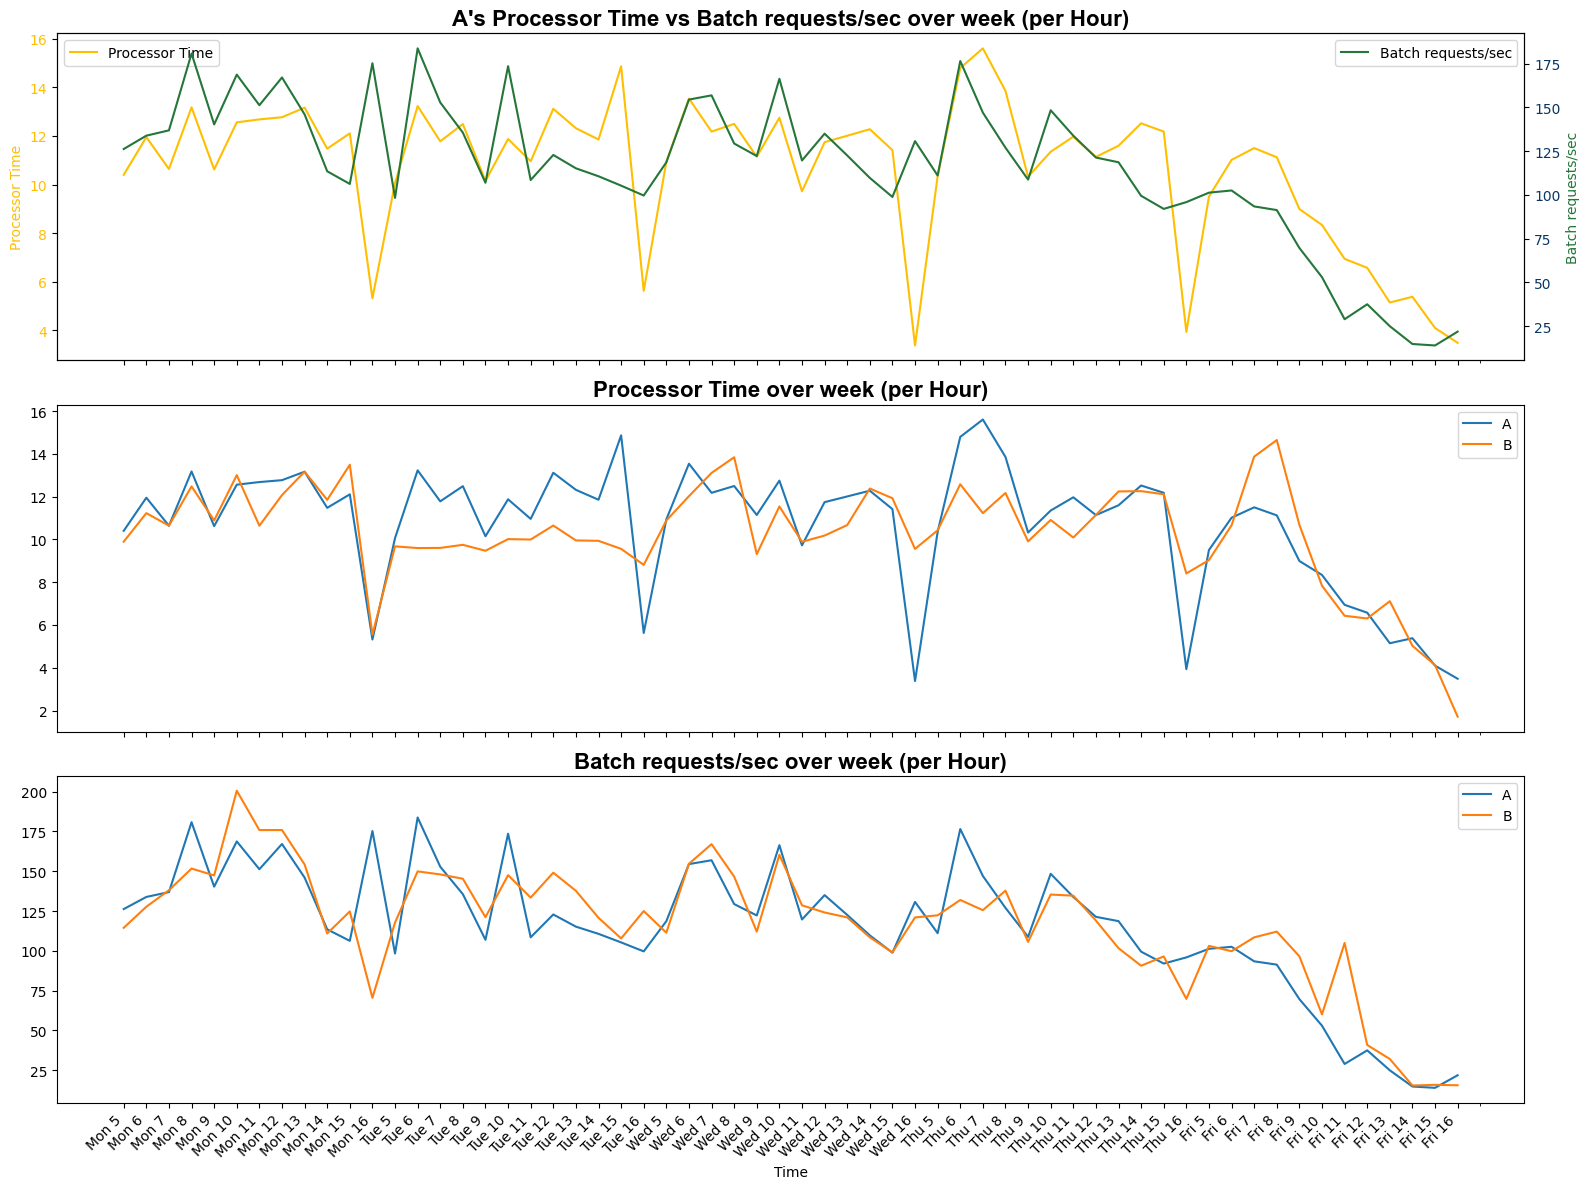

In [188]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(16,12), sharex=True)

plot_workload_vs_performance_per_hour(df_A_daytime,"A", 'Batch requests/sec','Processor Time', ax1)
plot_A_vs_B_metric_per_hour('Processor Time', ax2)
plot_A_vs_B_metric_per_hour('Batch requests/sec', ax3)
plt.tight_layout()

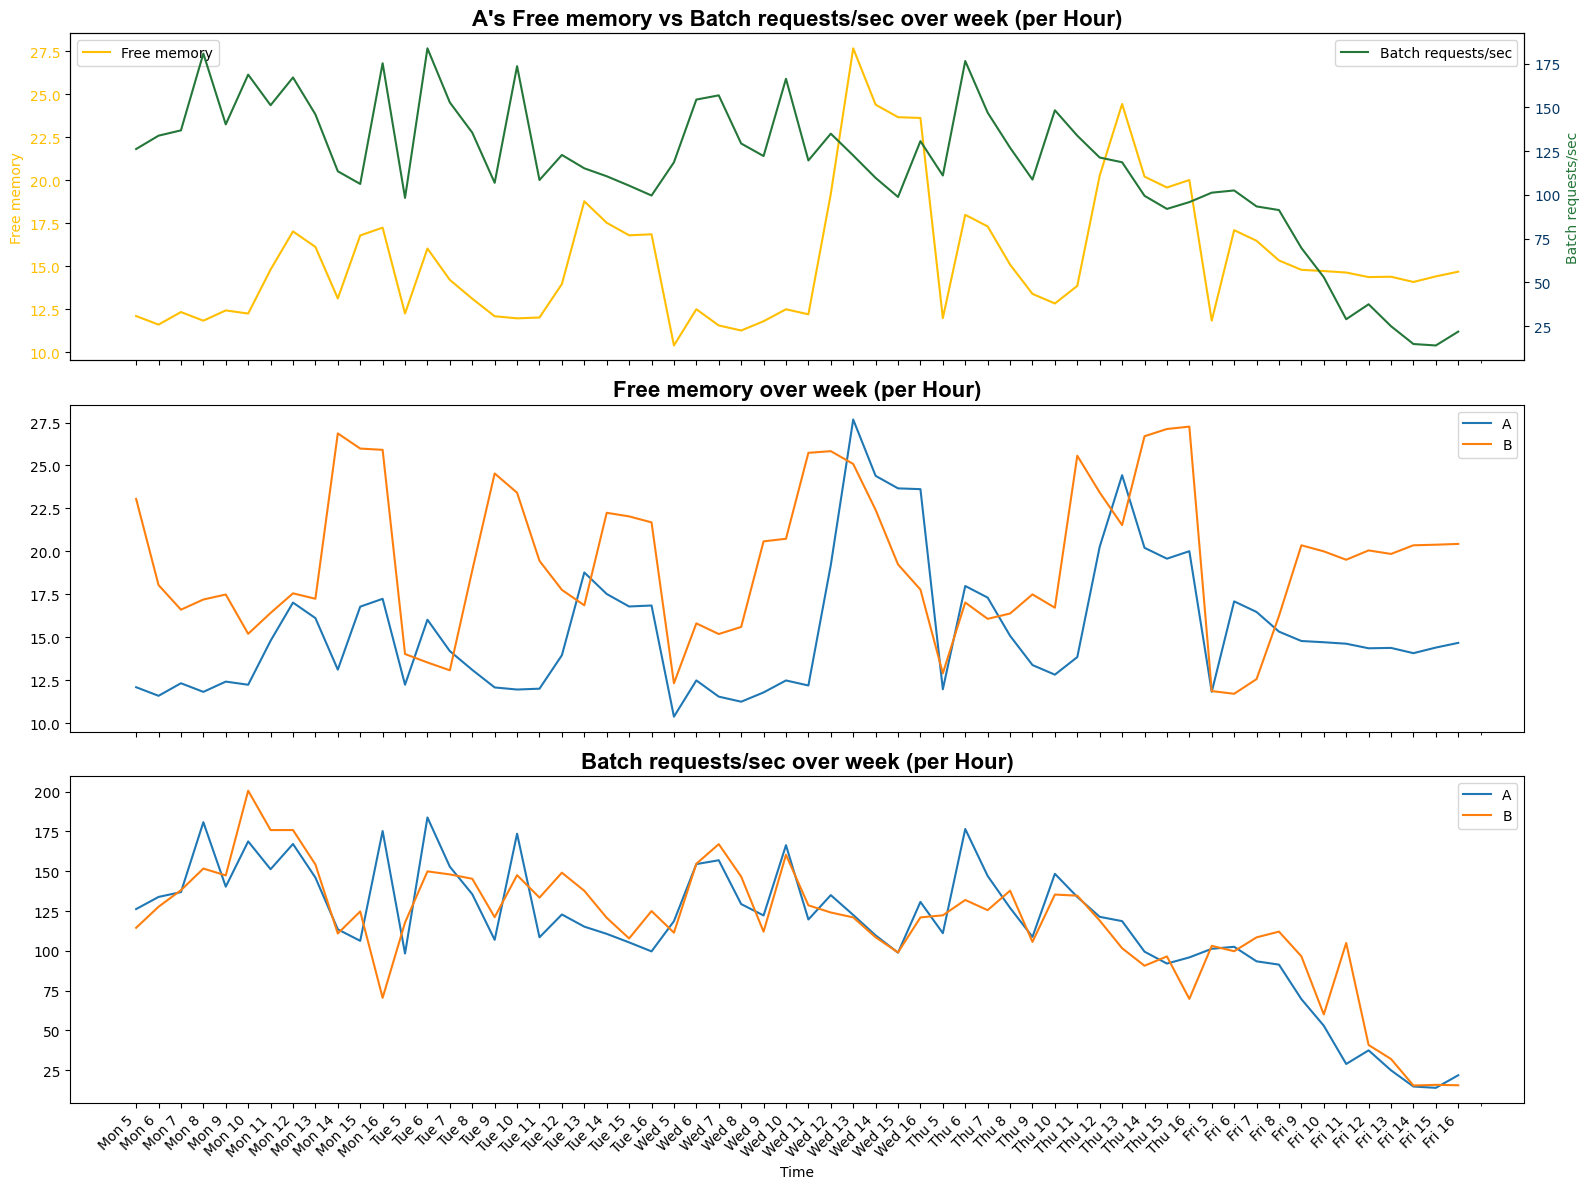

In [189]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(16,12), sharex=True)

plot_workload_vs_performance_per_hour(df_A_daytime, 'A','Batch requests/sec','Free memory', ax1)

plot_A_vs_B_metric_per_hour('Free memory', ax2)
plot_A_vs_B_metric_per_hour('Batch requests/sec', ax3)

plt.tight_layout()


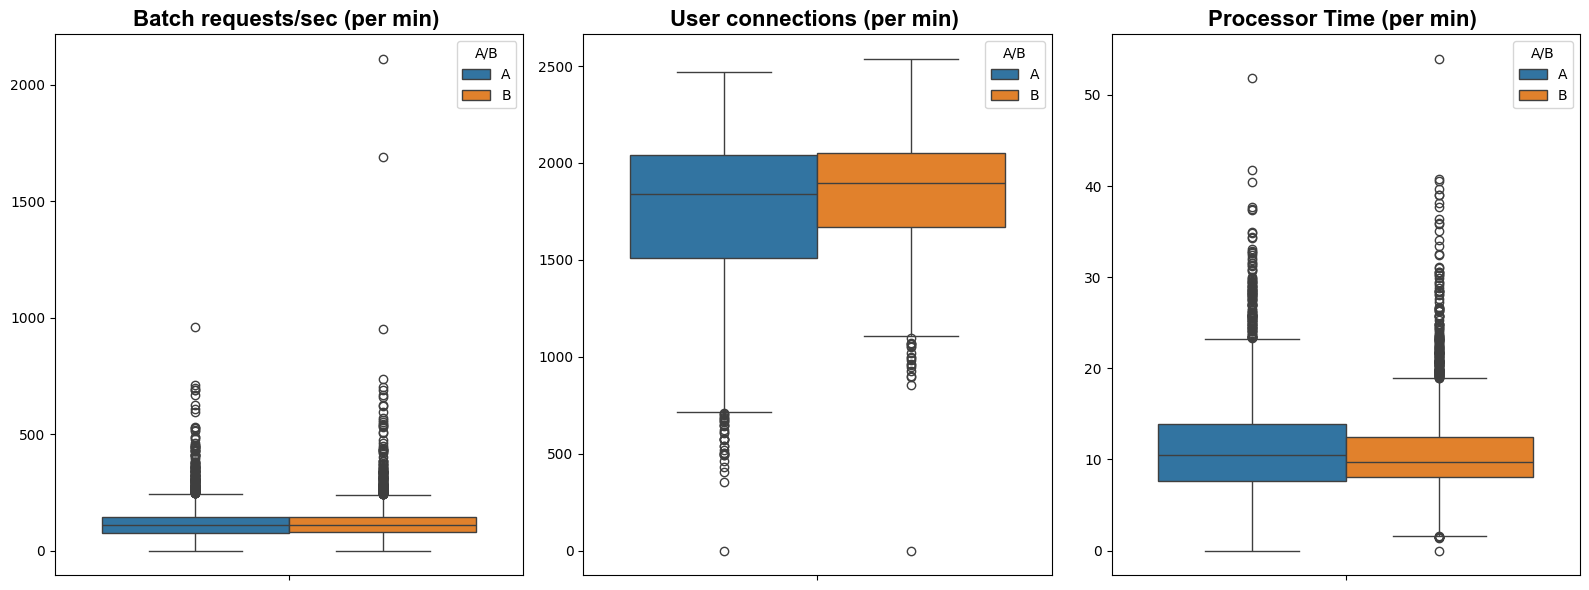

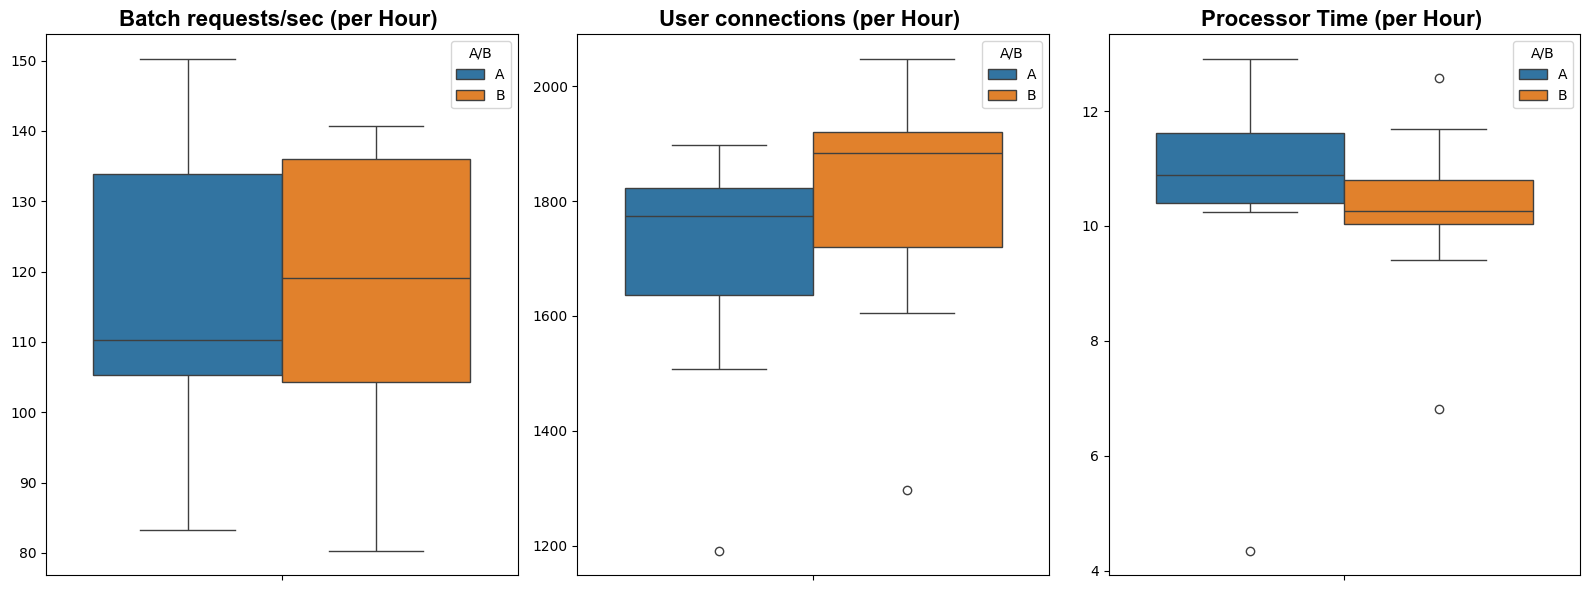

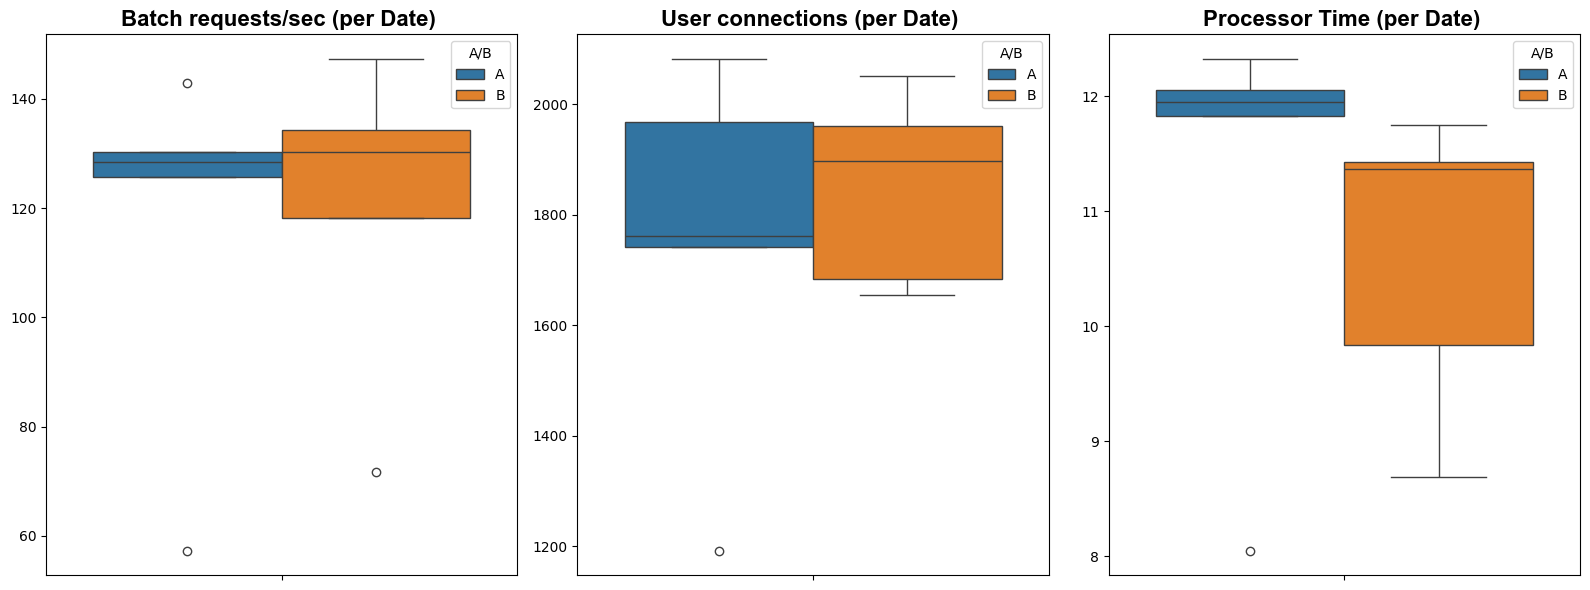

In [190]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,6))
plot_boxplot('Batch requests/sec', ax1)
plot_boxplot('User connections', ax2)
plot_boxplot('Processor Time', ax3)
plt.tight_layout()
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,6))
plot_boxplot('Batch requests/sec', ax1, 'Hour')
plot_boxplot('User connections', ax2,'Hour')
plot_boxplot('Processor Time', ax3,'Hour')
plt.tight_layout()
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,6))
plot_boxplot('Batch requests/sec', ax1, 'Date')
plot_boxplot('User connections', ax2,'Date')
plot_boxplot('Processor Time', ax3,'Date')
plt.tight_layout()

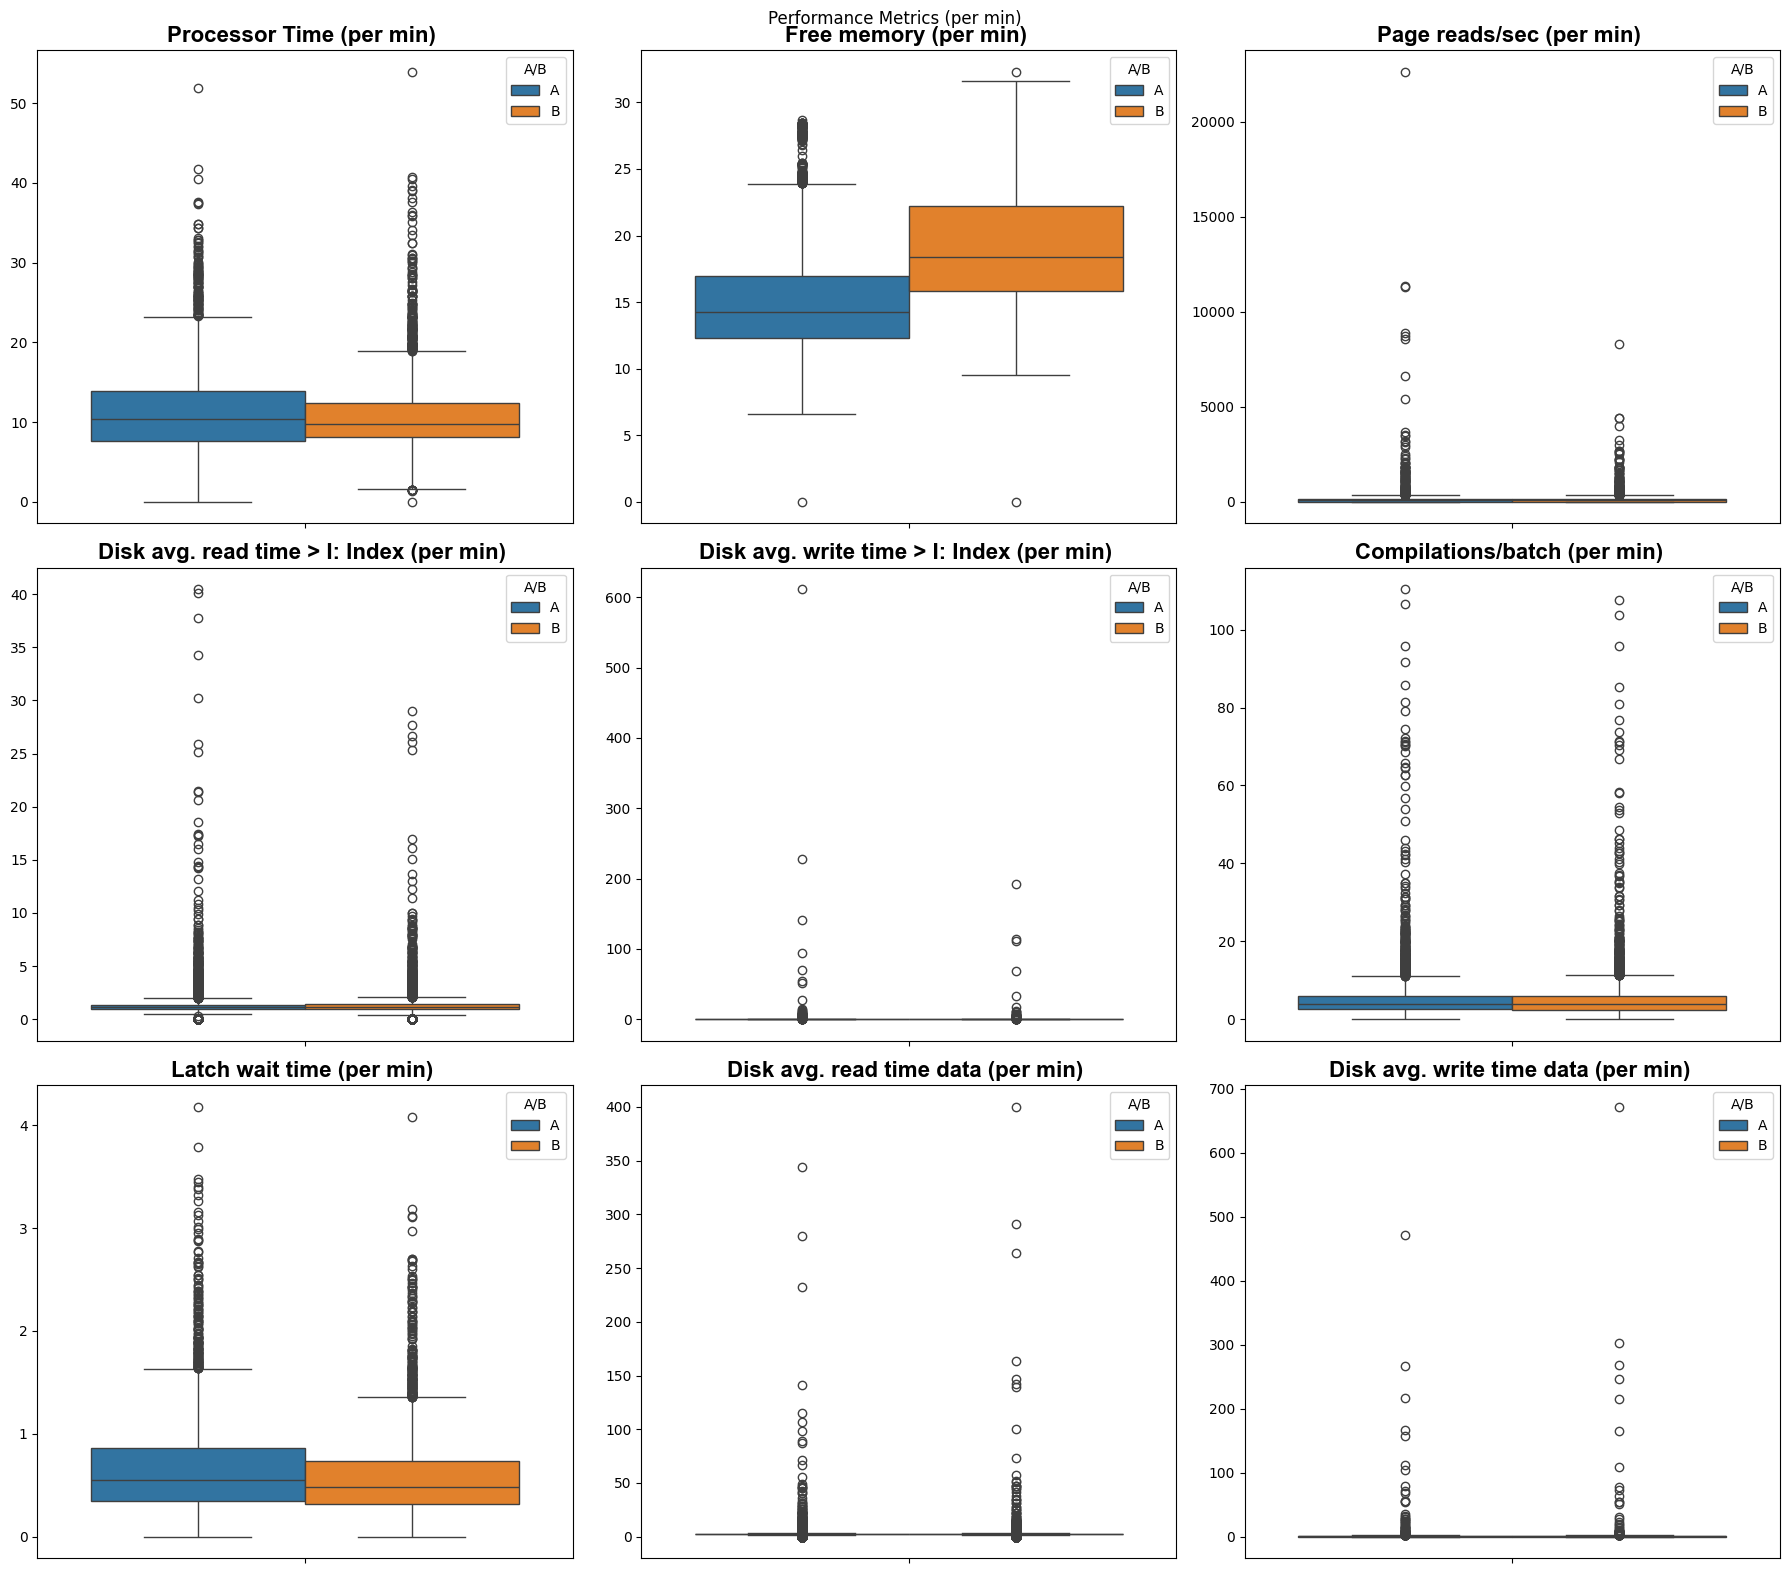

In [191]:
fig, axes = plt.subplots(3,3, figsize = (18,16))
axes = axes.flatten()
for i,perf_col in enumerate(perf_cols):
  plot_boxplot(perf_col,axes[i])
fig.suptitle('Performance Metrics (per min)')
plt.tight_layout()
plt.show()


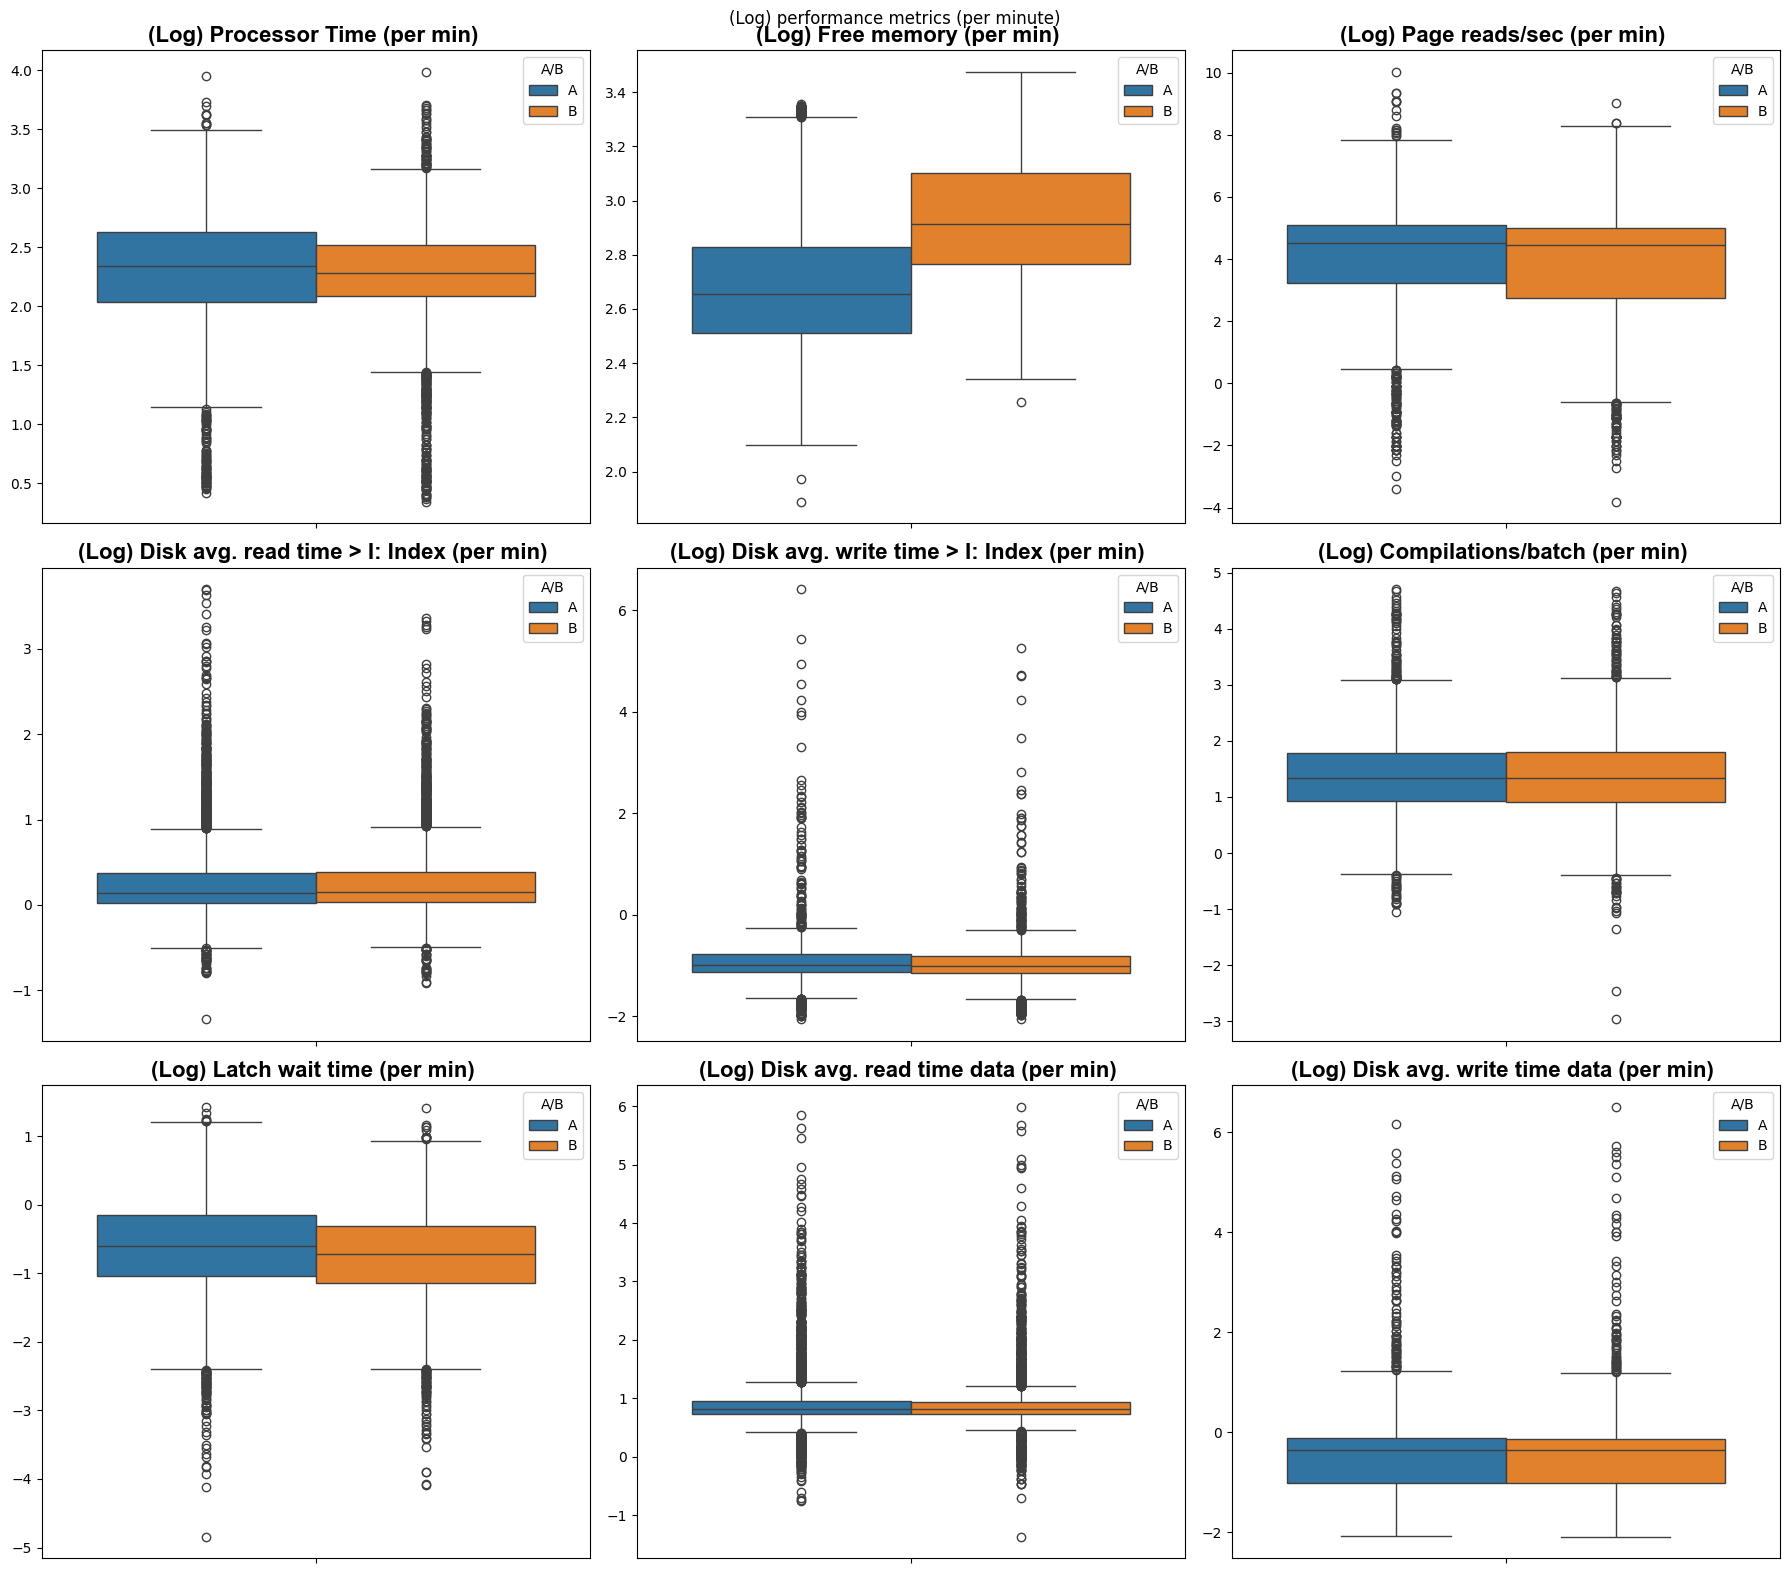

In [192]:
fig, axes = plt.subplots(3,3, figsize = (18,16))
axes = axes.flatten()
for i,perf_col in enumerate(perf_cols):
  plot_boxplot('(Log) '+perf_col,axes[i])
fig.suptitle('(Log) performance metrics (per minute)')
plt.tight_layout()
plt.show()


In [193]:
df_A_daytime = df_A_daytime.reset_index(drop=True)


In [194]:
df_B_daytime = df_B_daytime[:-3]


In [195]:
df_B_daytime = df_B_daytime.reset_index(drop=True)

In [196]:
def permutation_test(metric, df1, df2):
    combined_free_memory = np.concatenate([df1[metric].values, df2[metric].values])
    n_simulations = 1000

    size_1 = len(df1)

    simulated_diffs = []

    for i in range(n_simulations):
        np.random.shuffle(combined_free_memory)
        simulated_A = combined_free_memory[:size_1]
        simulated_B = combined_free_memory[size_1:]
        simulated_diff = np.mean(simulated_A) - np.mean(simulated_B)
        simulated_diffs.append(simulated_diff)

    real_diff = np.mean(df1[metric]) - np.mean(df2[metric])

    upper_bound = np.quantile(simulated_diffs, 0.95)
    lower_bound = np.quantile(simulated_diffs, 0.05)

    p_value = np.mean(np.abs(simulated_diffs) >= np.abs(real_diff))

    return upper_bound, lower_bound, real_diff, p_value






In [197]:
len(metric_cols)

11

In [373]:
significant_diffs = []
for i,col in enumerate(metric_cols):
  upper_bound, lower_bound, real_diff, p_value = permutation_test(col,df_A_daytime, df_B_daytime)
  print(col)
  print(f"Lower Bound: {lower_bound}")
  print(f"Upper Bound: {upper_bound}")
  print(f"real_diff: {real_diff}")
  print(p_value)
  if p_value<0.05:
      
      print('=>The difference between two samples are significant\n')
      significant_diffs.append(col)
  else: 
      print('=>The difference between two samples are not significant\n')
      



Batch requests/sec
Lower Bound: -2.991582864593121
Upper Bound: 3.169077140857857
real_diff: -3.502831997583087
0.07
=>The difference between two samples are not significant

User connections
Lower Bound: -12.830871378553057
Upper Bound: 12.986630538865787
real_diff: -100.86433890064336
0.0
=>The difference between two samples are significant

Processor Time
Lower Bound: -0.2000079689204961
Upper Bound: 0.2140173391166767
real_diff: 0.620286184945126
0.0
=>The difference between two samples are significant

Free memory
Lower Bound: -0.189404542751258
Upper Bound: 0.19204441643751569
real_diff: -3.906294503446336
0.0
=>The difference between two samples are significant

Page reads/sec
Lower Bound: -20.329007941034316
Upper Bound: 19.7723554295074
real_diff: 28.355693378980362
0.016
=>The difference between two samples are significant

Disk avg. read time > I: Index
Lower Bound: -0.08361537815847221
Upper Bound: 0.07766699049560544
real_diff: 0.013264711438810695
0.774
=>The difference b

In [374]:
significant_diffs

['User connections',
 'Processor Time',
 'Free memory',
 'Page reads/sec',
 'Latch wait time']

In [241]:
df_A_daytime['Day_name'].unique()

['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
Categories (5, object): ['Mon' < 'Tue' < 'Wed' < 'Thu' < 'Fri']

In [264]:
metric_cols

['Batch requests/sec',
 'User connections',
 'Processor Time',
 'Free memory',
 'Page reads/sec',
 'Disk avg. read time > I: Index',
 'Disk avg. write time > I: Index',
 'Compilations/batch',
 'Latch wait time',
 'Disk avg. read time data',
 'Disk avg. write time data']

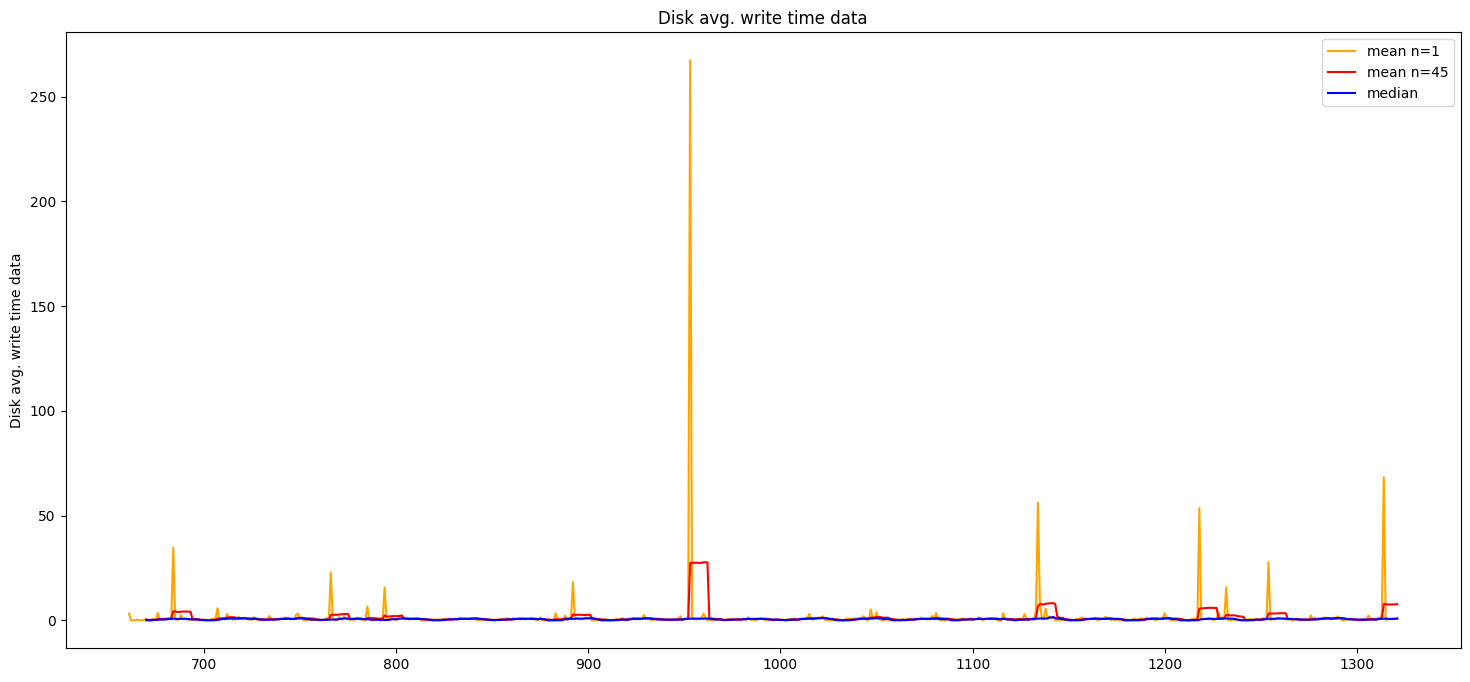

In [343]:
window_sizes = [1,40]
plt.figure(figsize=(18,8))
sma = df_A_daytime[df_A_daytime['Day_name']=='Tue']['Disk avg. write time data'].rolling(window = 1).mean()
sns.lineplot(sma, label=f'mean n={1}',color='orange')
sma_0 = df_A_daytime[df_A_daytime['Day_name']=='Tue']['Disk avg. write time data'].rolling(window =10 ).mean()
sns.lineplot(sma_0, label=f'mean n={45}',color='red')
plt.title(f'{col}')
sma_2 = df_A_daytime[df_A_daytime['Day_name']=='Tue']['Disk avg. write time data'].rolling(window = 10).median()

sns.lineplot(sma_2, label=f'median',color='blue')
plt.legend()



<Axes: ylabel='Disk avg. write time data'>

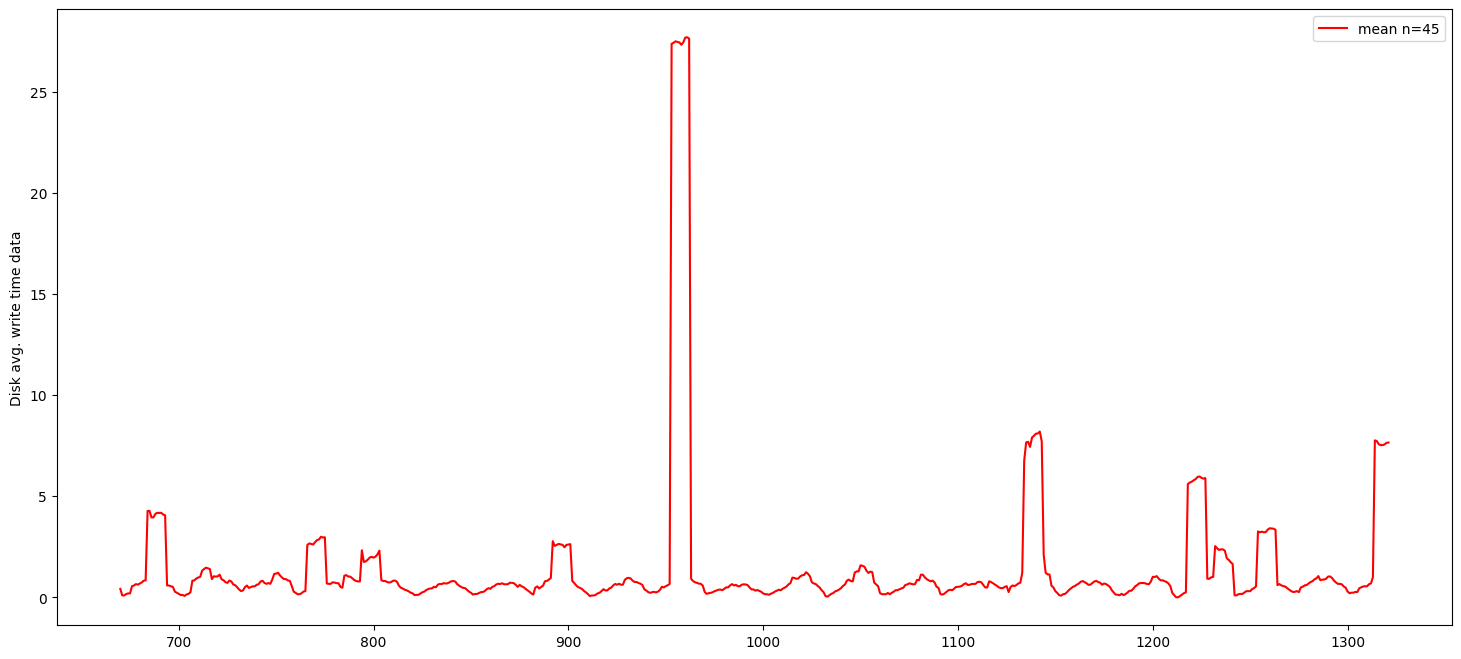

In [347]:
plt.figure(figsize=(18,8))
sma_0 = df_A_daytime[df_A_daytime['Day_name']=='Tue']['Disk avg. write time data'].rolling(window =10 ).mean()
sns.lineplot(sma_0, label=f'mean n={45}',color='red')

In [362]:
df_A_daytime

Day_name        Date      Time             DateTime  Batch requests/sec  \
0         Mon  2024-05-06  05:00:00  2024-05-06 05:00:00           69.180363   
1         Mon  2024-05-06  05:01:00  2024-05-06 05:01:00           57.220157   
2         Mon  2024-05-06  05:02:00  2024-05-06 05:02:00           61.292631   
3         Mon  2024-05-06  05:03:00  2024-05-06 05:03:00           66.741153   
4         Mon  2024-05-06  05:04:00  2024-05-06 05:04:00           63.210600   
...       ...         ...       ...                  ...                 ...   
3300      Fri  2024-05-03  15:56:00  2024-05-03 15:56:00           11.056499   
3301      Fri  2024-05-03  15:57:00  2024-05-03 15:57:00            9.307507   
3302      Fri  2024-05-03  15:58:00  2024-05-03 15:58:00           17.485626   
3303      Fri  2024-05-03  15:59:00  2024-05-03 15:59:00           15.745990   
3304      Fri  2024-05-03  16:00:00  2024-05-03 16:00:00           21.796917   

      User connections  Processor Time  Free memory  Page reads/sec  \
0                355.0        7.506058    13.651604        8.311422   
1                407.0       12.033391    13.104340      866.912023   
2                431.0        9.501151    12.818169     1031.692813   
3                462.5       16.526169    12.783623      298.314704   
4                500.0       13.711746    12.357361      600.217167   
...                ...             ...          ...             ...   
3300            1581.0        1.654298    14.639626        0.000000   
3301            1577.0        1.719531    14.663597        0.000000   
3302            1577.5        4.508345    14.635677      100.284978   
3303            1578.0        1.676018    14.585320        0.000000   
3304            1585.0        3.485834    14.674919       67.023855   

      Disk avg. read time > M: Data 1  ...  Disk avg. read time > I: Index  \
0                             1.46490  ...                          1.2450   
1                             1.28130  ...                          1.2369   
2                             8.39560  ...                          3.5883   
3                             2.16380  ...                          0.9824   
4                             2.72640  ...                          1.2945   
...                               ...  ...                             ...   
3300                          0.00000  ...                          0.0000   
3301                          0.00000  ...                          0.0000   
3302                          0.00000  ...                          0.0000   
3303                          0.47575  ...                          0.0000   
3304                          1.20680  ...                          0.0000   

      Disk avg. write time > M: Data 1  Disk avg. write time > N: Data 2  \
0                              0.00000                            0.0000   
1                              0.00000                            0.0000   
2                              0.49940                            0.0000   
3                              0.55260                            0.0000   
4                              0.40565                            0.3711   
...                                ...                               ...   
3300                           0.00000                            0.0000   
3301                           0.00000                            0.0000   
3302                           0.00000                            0.0000   
3303                           0.31310                            0.0000   
3304                           0.32410                            0.3737   

      Disk avg. write time > I: Index  Compilations/batch  Latch wait time  \
0                              0.0000           11.917764          0.19050   
1                              0.0000           16.763679          0.97300   
2                              0.0000            3.759942          0.97800   
3                            

In [363]:
df_B_daytime

Day_name        Date      Time             DateTime  Batch requests/sec  \
0         Mon  2024-04-29  05:00:00  2024-04-29 05:00:00           62.329500   
1         Mon  2024-04-29  05:01:00  2024-04-29 05:01:00           61.728701   
2         Mon  2024-04-29  05:02:00  2024-04-29 05:02:00           74.185804   
3         Mon  2024-04-29  05:03:00  2024-04-29 05:03:00           52.794239   
4         Mon  2024-04-29  05:04:00  2024-04-29 05:04:00           55.922727   
...       ...         ...       ...                  ...                 ...   
3297      Fri  2024-04-26  15:53:00  2024-04-26 15:53:00           14.159813   
3298      Fri  2024-04-26  15:54:00  2024-04-26 15:54:00           13.286804   
3299      Fri  2024-04-26  15:55:00  2024-04-26 15:55:00           14.762088   
3300      Fri  2024-04-26  15:56:00  2024-04-26 15:56:00           16.943670   
3301      Fri  2024-04-26  15:57:00  2024-04-26 15:57:00           14.327880   

      User connections  Processor Time  Free memory  Page reads/sec  \
0                854.0        5.704886    24.946648        9.244488   
1                901.0       14.740250    24.822937      154.166320   
2                898.0       12.797396    24.884659      110.870543   
3                926.0       14.677312    24.768181      391.522430   
4                946.0       17.407426    24.724800      146.830684   
...                ...             ...          ...             ...   
3297            1406.0        1.816626    20.438362        0.266538   
3298            1403.0        1.850230    20.411316        0.133034   
3299            1401.0        4.844501    20.425957        1.536326   
3300            1399.0        1.630239    20.422218        0.316548   
3301            1405.0        1.676157    20.422653        0.000000   

      Disk avg. read time > M: Data 1  ...  Disk avg. read time > I: Index  \
0                             1.69280  ...                         2.88810   
1                             1.91470  ...                         1.58660   
2                             1.27560  ...                         1.86370   
3                             1.19190  ...                         0.67930   
4                             1.19115  ...                         1.17715   
...                               ...  ...                             ...   
3297                          1.27700  ...                         0.00000   
3298                          0.00000  ...                         0.00000   
3299                          0.91200  ...                         0.00000   
3300                          0.00000  ...                         0.00000   
3301                          0.00000  ...                         0.00000   

      Disk avg. write time > M: Data 1  Disk avg. write time > N: Data 2  \
0                              0.00000                            0.0000   
1                              0.00000                            0.0000   
2                              0.52780                            0.5096   
3                              0.37170                            0.4224   
4                              0.16595                            0.1618   
...                                ...                               ...   
3297                           0.29420                            0.3415   
3298                           0.29200                            0.0000   
3299                           0.30730                            0.3645   
3300                           0.28310                            0.3807   
3301                           0.36770                            0.3664   

      Disk avg. write time > I: Index  Compilations/batch  Latch wait time  \
0                             0.00000           20.737573           0.4475   
1                             0.00000            7.985612           2.1812   
2                             0.28020            4.738379           0.2235   
3                            

In [368]:
merged = pd.merge(df_A_daytime[df_A_daytime['Day_name']=='Tue'], df_B_daytime[df_B_daytime['Day_name']=='Tue'], on='Time', how='inner')

In [369]:
merged

Day_name_x      Date_x      Time           DateTime_x  \
0          Tue  2024-04-23  05:00:00  2024-04-23 05:00:00   
1          Tue  2024-04-23  05:01:00  2024-04-23 05:01:00   
2          Tue  2024-04-23  05:02:00  2024-04-23 05:02:00   
3          Tue  2024-04-23  05:03:00  2024-04-23 05:03:00   
4          Tue  2024-04-23  05:04:00  2024-04-23 05:04:00   
..         ...         ...       ...                  ...   
656        Tue  2024-04-23  15:56:00  2024-04-23 15:56:00   
657        Tue  2024-04-23  15:57:00  2024-04-23 15:57:00   
658        Tue  2024-04-23  15:58:00  2024-04-23 15:58:00   
659        Tue  2024-04-23  15:59:00  2024-04-23 15:59:00   
660        Tue  2024-04-23  16:00:00  2024-04-23 16:00:00   

     Batch requests/sec_x  User connections_x  Processor Time_x  \
0              105.448268               930.0          6.905685   
1               53.870240               949.0         11.843749   
2              111.479363               993.0         25.060456   
3              142.449034              1054.0         13.492216   
4               59.791333              1113.0         14.372484   
..                    ...                 ...               ...   
656             48.894130              1197.0         19.109276   
657             63.225100              1182.0          5.585150   
658             69.579762              1167.0          5.575090   
659             44.510263              1148.0          7.608106   
660             99.624413              1134.5          5.627389   

     Free memory_x  Page reads/sec_x  Disk avg. read time > M: Data 1_x  ...  \
0        15.721504        167.332622                             1.6932  ...   
1        15.380089         98.468550                             2.0514  ...   
2        14.541435       2989.520128                             1.9358  ...   
3        14.010094        360.648336                             1.3950  ...   
4        14.445381        148.709634                             1.5680  ...   
..             ...               ...                                ...  ...   
656      16.865173          0.116613                             0.0000  ...   
657      16.862762          0.888305                             0.7295  ...   
658      16.862518         79.322261                             4.7110  ...   
659      16.809631         91.640083                             1.0690  ...   
660      16.850559         33.713904                             0.0000  ...   

     Disk avg. read time > I: Index_y  Disk avg. write time > M: Data 1_y  \
0                             1.81060                              0.3732   
1                             1.07250                              0.3845   
2                             1.81335                              0.2056   
3                             1.28210                              0.3625   
4                             1.32680                              0.3673   
..                                ...                                 ...   
656                           1.46580                              0.4507   
657                           0.92200                              0.3408   
658                           0.00000                              0.3270   
659                           1.04250                              0.8269   
660                           1.00410                              0.4861   

     Disk avg. write time > N: Data 2_y  Disk avg. write time > I: Index_y  \
0                                0.4187                             0.0000   
1                                0.3871                             0.0000   
2                                0.0000                             0.0000   
3                                0.4144                             0.3301   
4                                0.3952                             0.0000   
..                                  ...                                ...   
656                              0

In [355]:
df_B_daytime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3302 entries, 0 to 3301
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Day_name                          3302 non-null   category
 1   Date                              3302 non-null   object  
 2   Time                              3302 non-null   object  
 3   DateTime                          3302 non-null   object  
 4   Batch requests/sec                3302 non-null   float64 
 5   User connections                  3302 non-null   float64 
 6   Processor Time                    3302 non-null   float64 
 7   Free memory                       3302 non-null   float64 
 8   Page reads/sec                    3302 non-null   float64 
 9   Disk avg. read time > M: Data 1   3302 non-null   float64 
 10  Disk avg. read time > N: Data 2   3302 non-null   float64 
 11  Disk avg. read time > I: Index    3302 non-null   float6

In [370]:
merged.columns

Index(['Day_name_x', 'Date_x', 'Time', 'DateTime_x', 'Batch requests/sec_x',
       'User connections_x', 'Processor Time_x', 'Free memory_x',
       'Page reads/sec_x', 'Disk avg. read time > M: Data 1_x',
       'Disk avg. read time > N: Data 2_x', 'Disk avg. read time > I: Index_x',
       'Disk avg. write time > M: Data 1_x',
       'Disk avg. write time > N: Data 2_x',
       'Disk avg. write time > I: Index_x', 'Compilations/batch_x',
       'Latch wait time_x', 'Disk avg. read time data_x',
       'Disk avg. write time data_x', 'A/B_x', 'Hour_x', 'Day_name_y',
       'Date_y', 'DateTime_y', 'Batch requests/sec_y', 'User connections_y',
       'Processor Time_y', 'Free memory_y', 'Page reads/sec_y',
       'Disk avg. read time > M: Data 1_y',
       'Disk avg. read time > N: Data 2_y', 'Disk avg. read time > I: Index_y',
       'Disk avg. write time > M: Data 1_y',
       'Disk avg. write time > N: Data 2_y',
       'Disk avg. write time > I: Index_y', 'Compilations/batch_y',
   

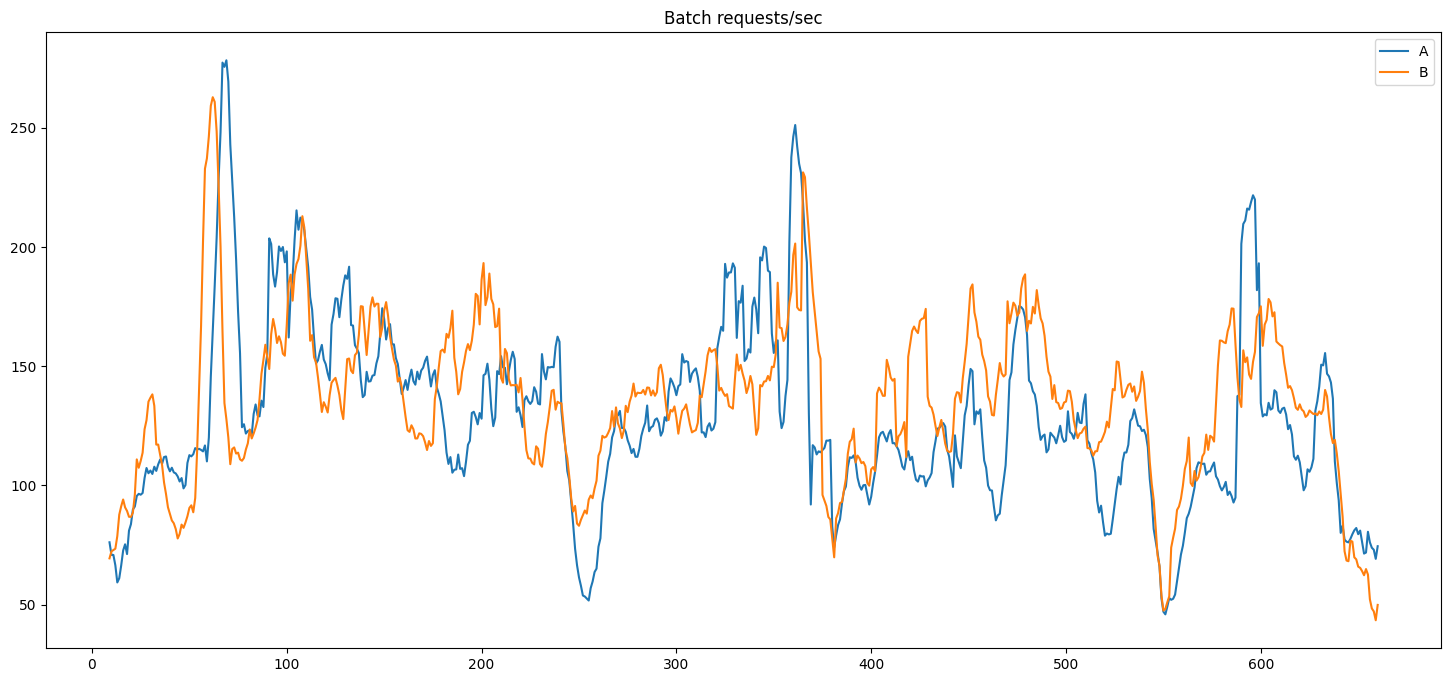

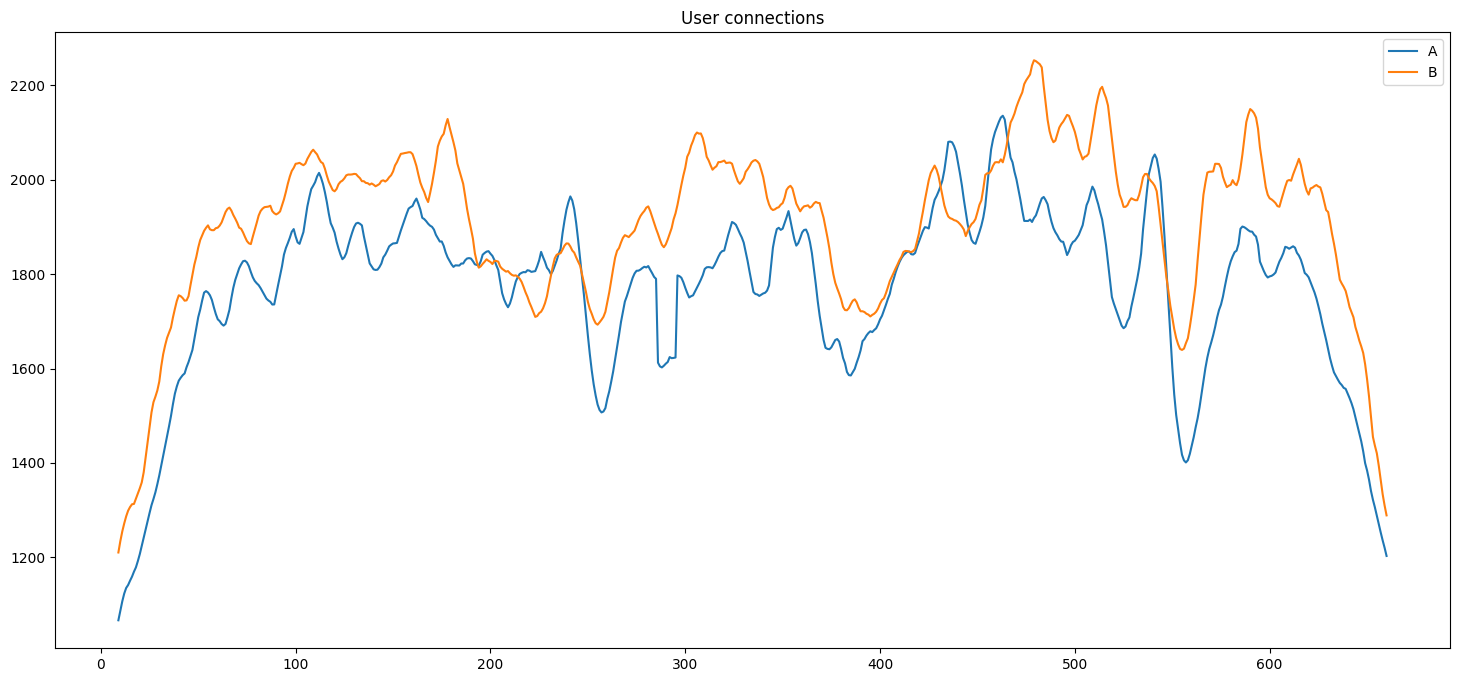

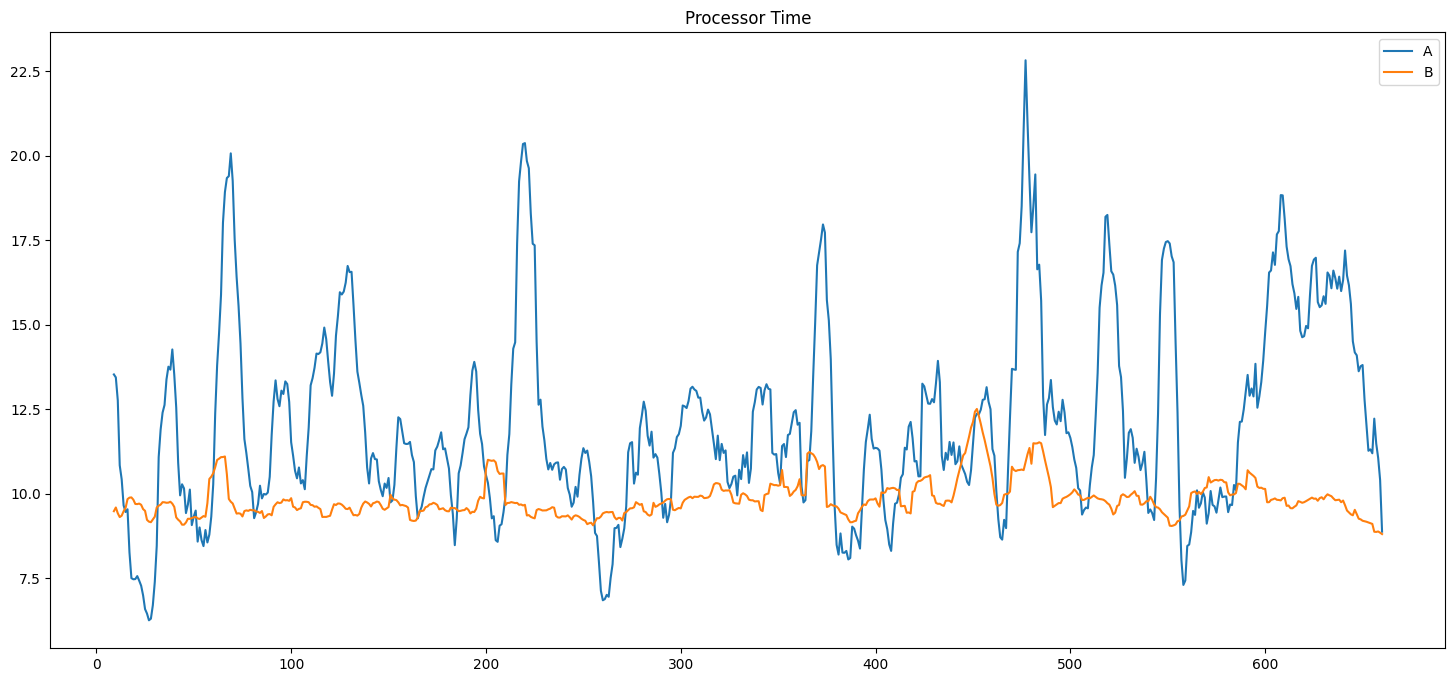

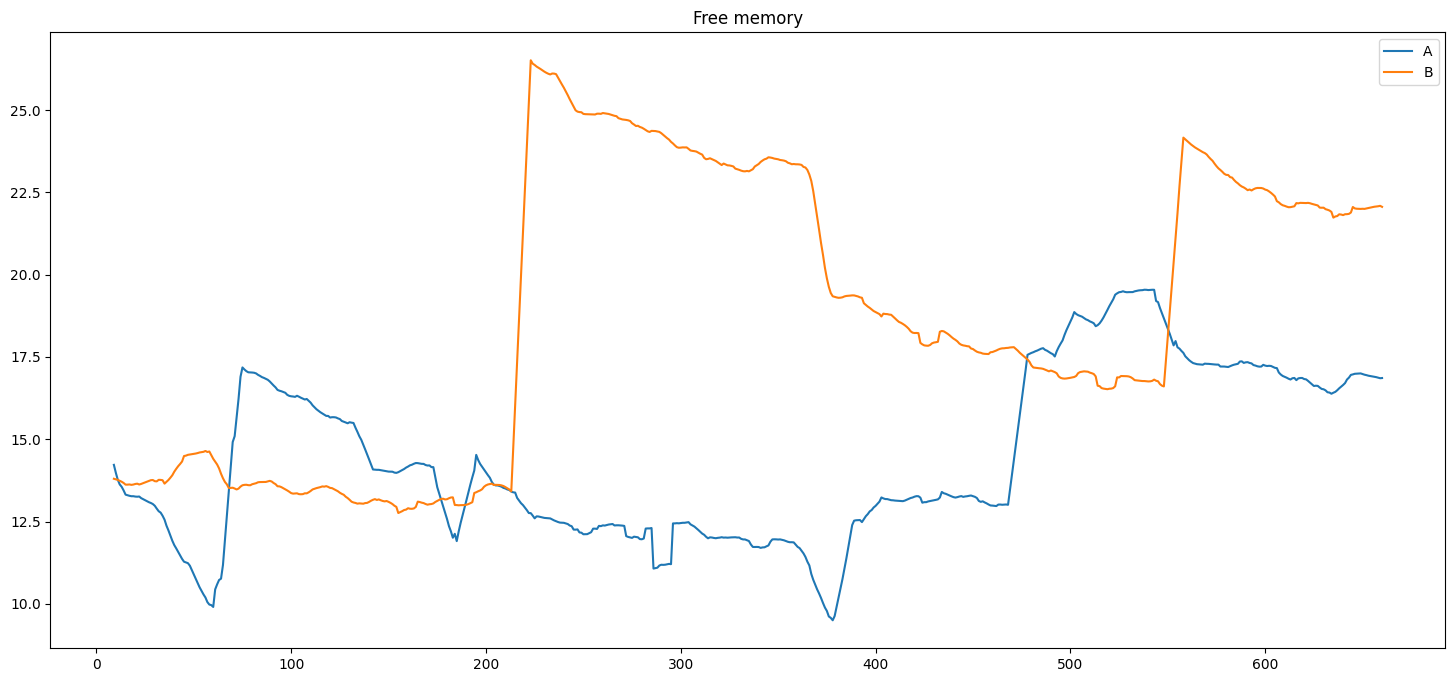

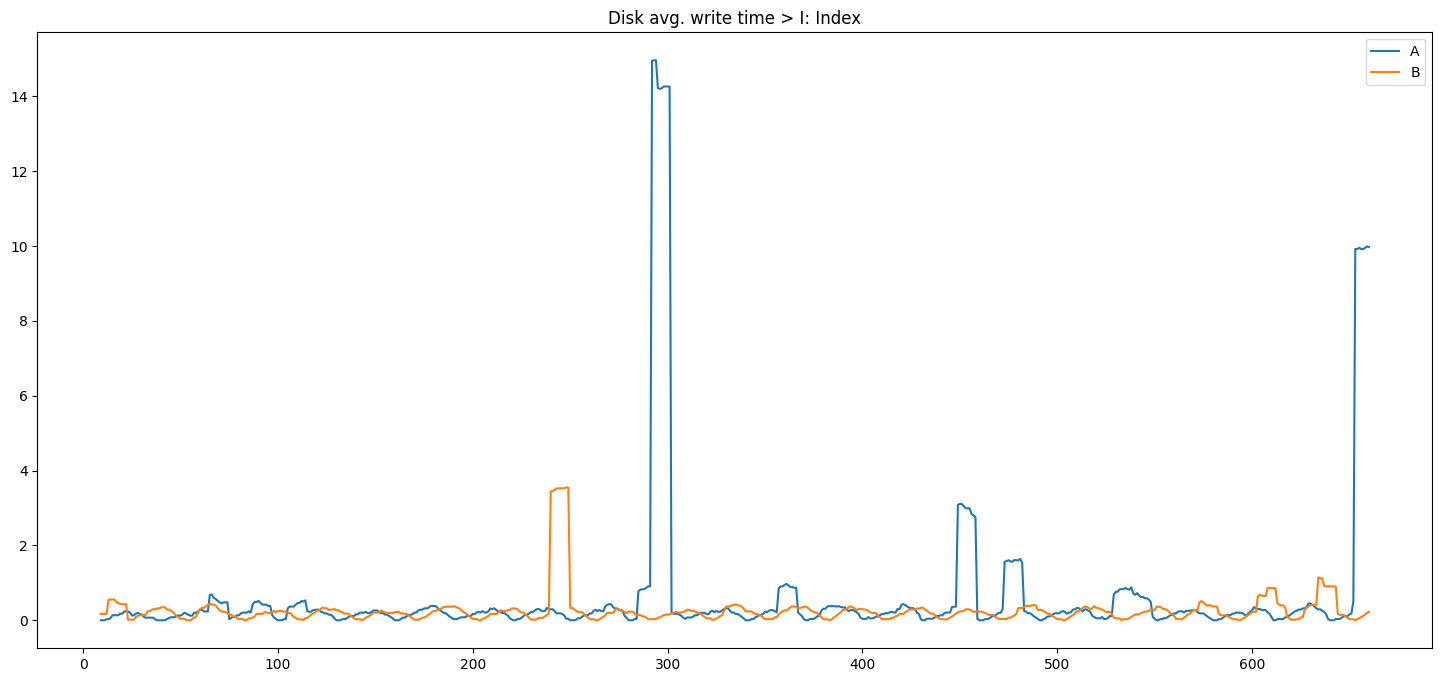

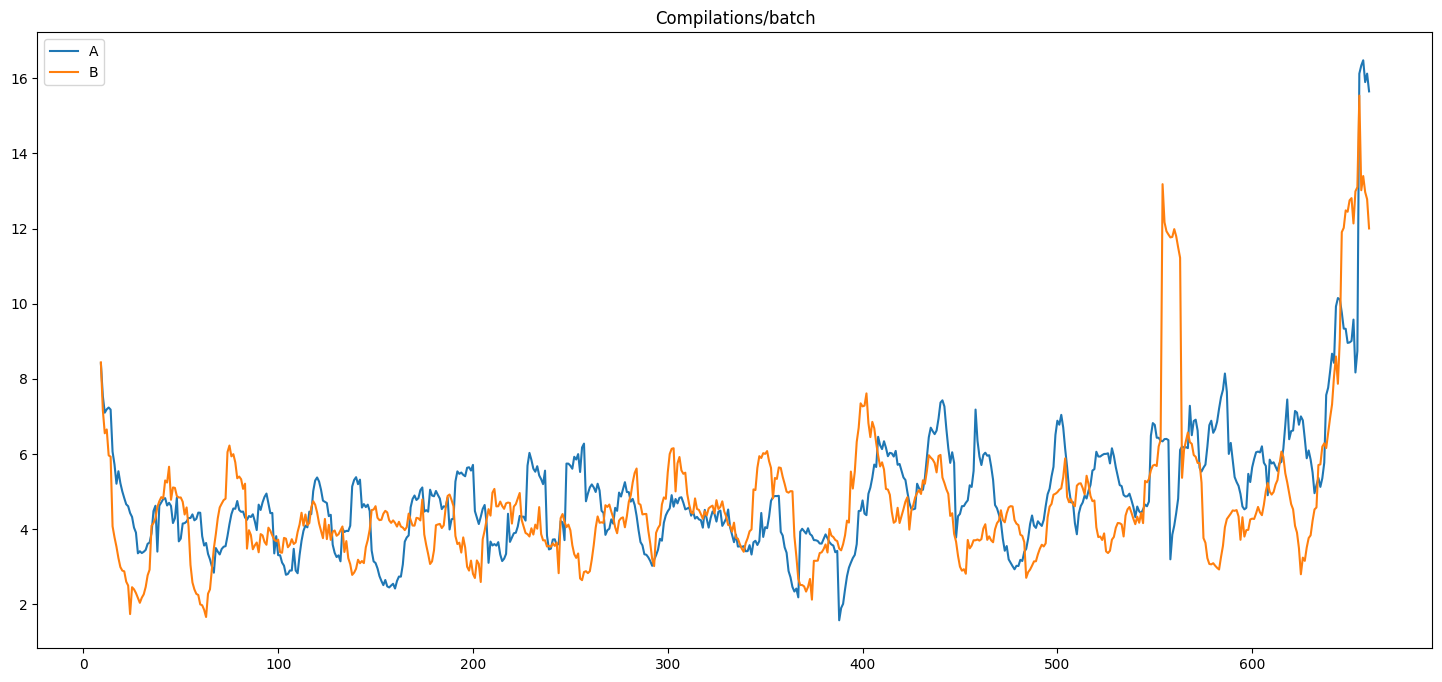

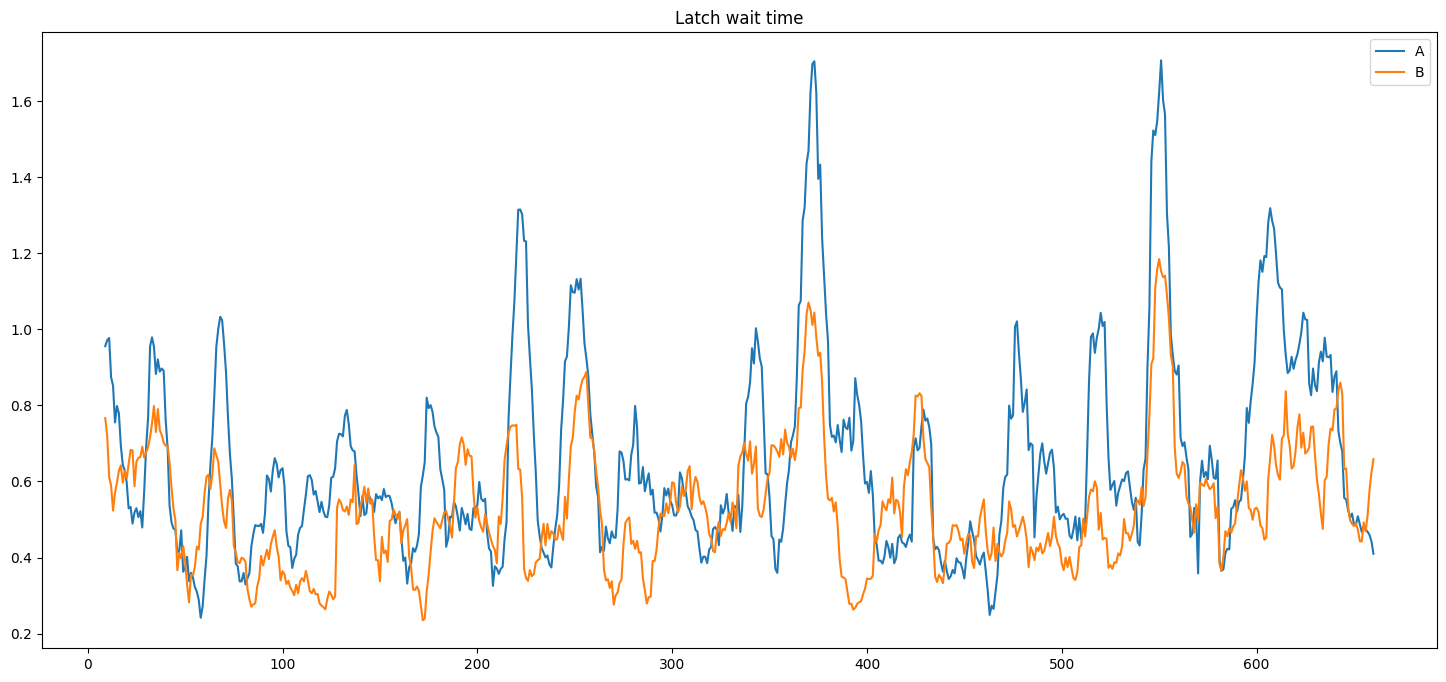

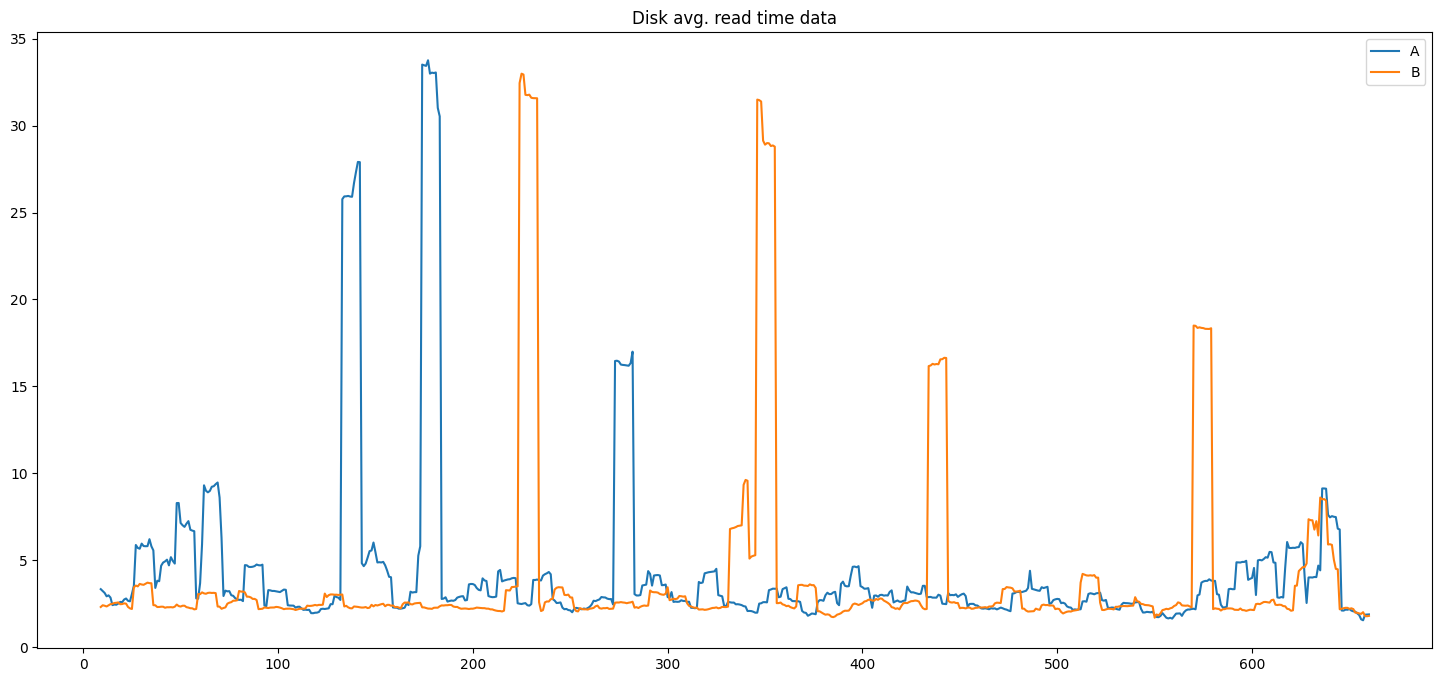

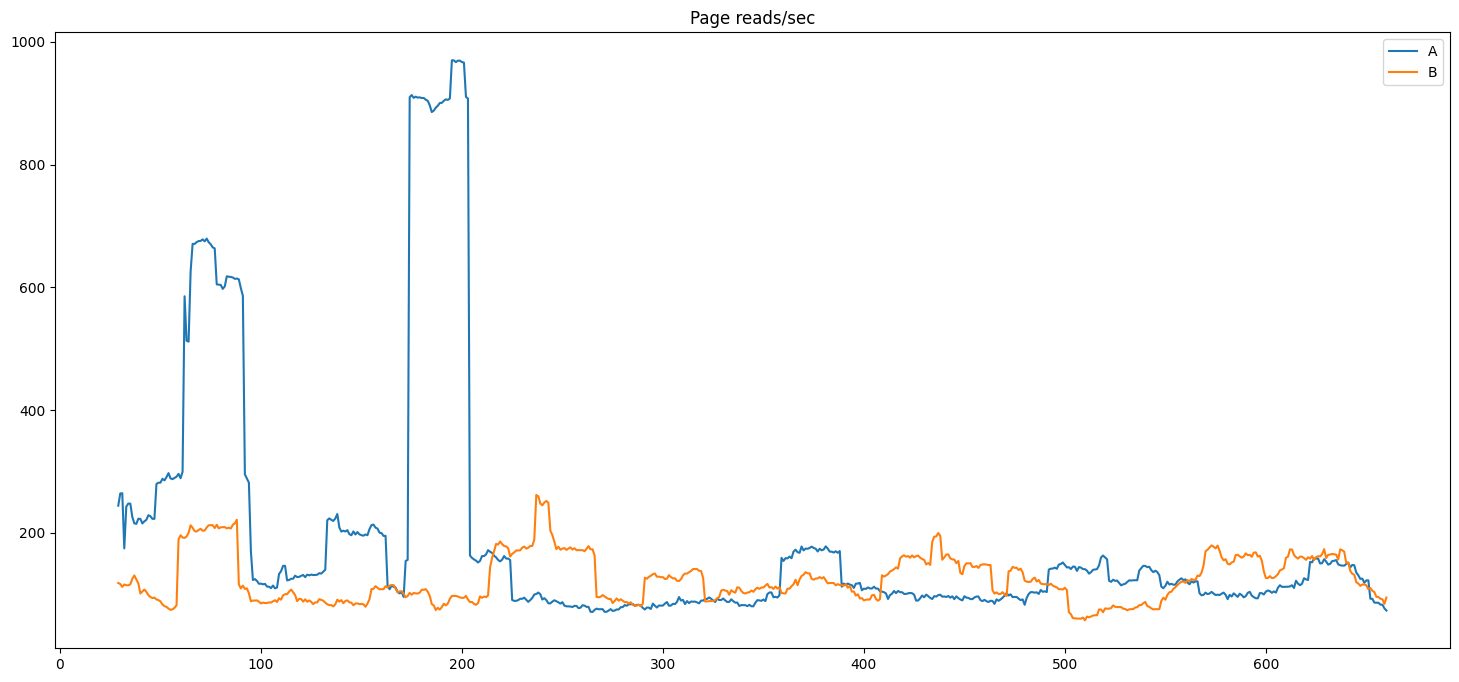

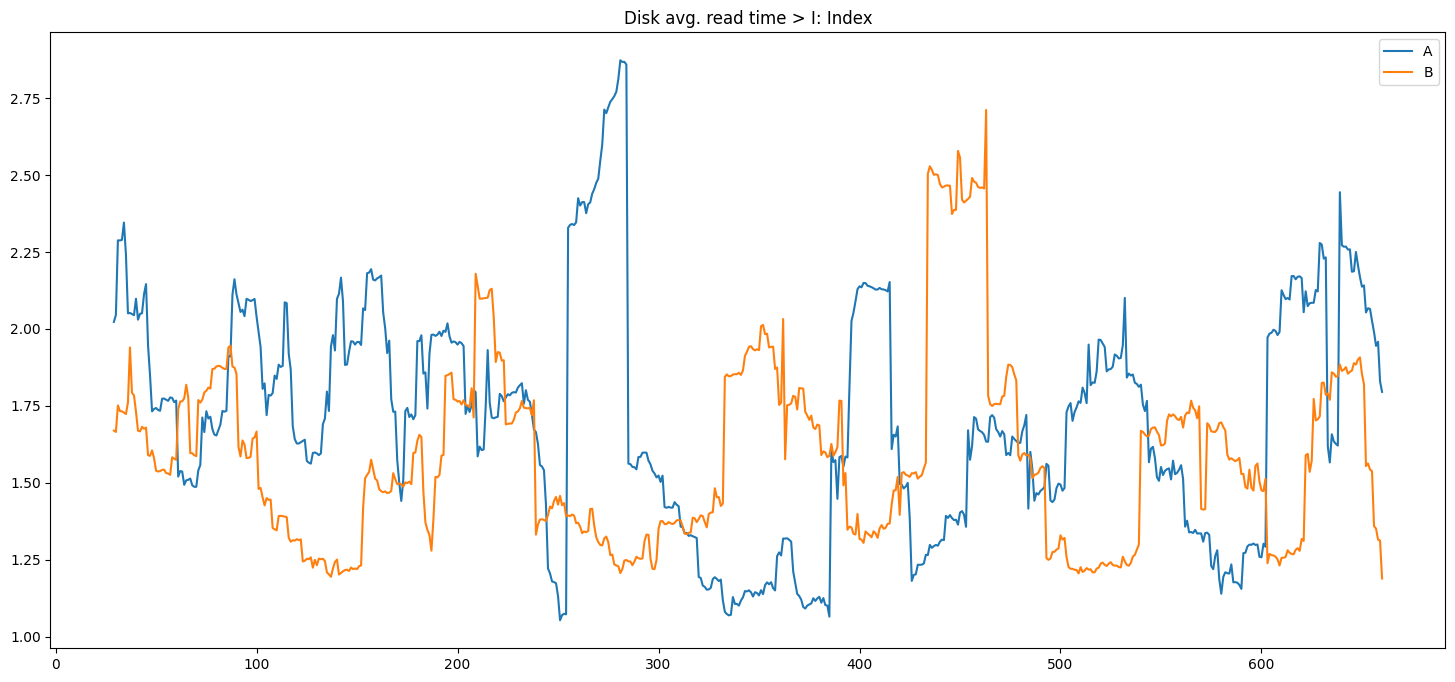

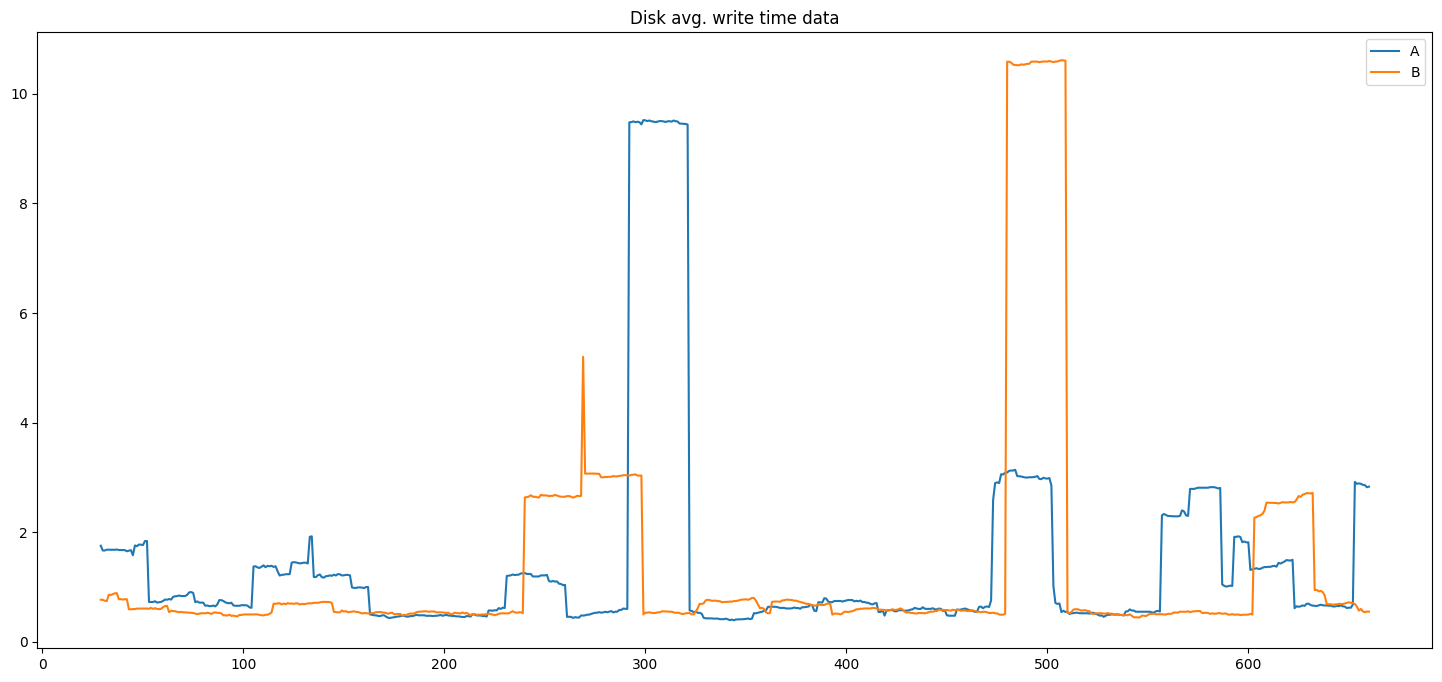

In [372]:
metric_col_size_10 = ['Batch requests/sec', 
                      'User connections', 
                      'Processor Time', 
                      'Free memory',
                      'Disk avg. write time > I: Index', 
                      'Compilations/batch', 
                      'Latch wait time',
                      'Disk avg. read time data']

metric_col_size_30 = ['Page reads/sec',
                      'Disk avg. read time > I: Index',
                      'Disk avg. write time data']
for i,col in enumerate(metric_col_size_10):

  plt.figure(figsize=(18,8))
  window_size = 10
  sma_A = merged[merged['Day_name_x']=='Tue'][f'{col}_x'].rolling(window = window_size).mean()
  sma_B = merged[merged['Day_name_x']=='Tue'][f'{col}_y'].rolling(window = window_size).mean()
  plt.subplot()
  plt.plot(sma_A, label=f'A')
  plt.plot(sma_B, label=f'B')
  plt.title(f'{col}')
  plt.legend()

for i,col in enumerate(metric_col_size_30):

  plt.figure(figsize=(18,8))
  window_size = 30
  sma_A = merged[merged['Day_name_x']=='Tue'][f'{col}_x'].rolling(window = window_size).mean()
  sma_B = merged[merged['Day_name_x']=='Tue'][f'{col}_y'].rolling(window = window_size).mean()
  plt.subplot()
  plt.plot(sma_A, label=f'A')
  plt.plot(sma_B, label=f'B')
  plt.title(f'{col}')
  plt.legend()

